# Amazon Review Traditional ML Approach

**Author:** Carine Ahishakiye Yibukabayo  
**Date:** February 8, 2026  



## Overview

This notebook implements a comprehensive sentiment classification system for Amazon Fine Food Reviews using traditional machine learning methodologies:

- **Text Preprocessing**: Advanced text cleaning pipeline with tokenization, lemmatization, and stopword removal
- **Feature Extraction**: Three embedding approaches - TF-IDF, Word2Vec Skip-gram, and Word2Vec CBOW
- **Classification Model**: Logistic Regression with systematic hyperparameter optimization
- **Evaluation Framework**: Performance metrics, confusion matrices, and statistical significance testing (McNemar's test)

**Objective**: Predict star ratings (1-5 stars) from customer review text and perform comparative analysis of text representation techniques to identify optimal approaches for sentiment classification tasks.

In [15]:
# INSTALLATION AND SETUP
# Install required packages
!pip install gensim wordcloud beautifulsoup4 -q
print(" All packages installed successfully")

# IMPORT LIBRARIES AND CONFIGURATION

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
import random
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("LIBRARIES IMPORTED SUCCESSFULLY")
print("\nPython Environment Configured:")
print(f"  • NumPy version: {np.__version__}")
print(f"  • Pandas version: {pd.__version__}")
print(f"  • Matplotlib version: {plt.matplotlib.__version__}")
print(f"  • Random seed: 42 (for reproducibility)")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 79.6 MB/s eta 0:00:00
 All packages installed successfully
LIBRARIES IMPORTED SUCCESSFULLY

Python Environment Configured:
  • NumPy version: 2.0.2
  • Pandas version: 2.2.2
  • Matplotlib version: 3.10.0
  • Random seed: 42 (for reproducibility)


In [17]:
# DATASET LOADING


from google.colab import drive
drive.mount('/content/drive')
print("LOADING AMAZON FINE FOOD REVIEWS DATASET")

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Grp 15 ML techniques/Reviews.csv')

print("\n Dataset loaded successfully")
print(f"\nDataset Dimensions:")
print(f"  Total Records: {len(df):,}")
print(f"  Total Features: {df.shape[1]}")
print(f"  Shape: {df.shape}")

print("DATASET SAMPLING STRATEGY")



USE_SAMPLE = False
SAMPLE_SIZE = 100000

if USE_SAMPLE and len(df) > SAMPLE_SIZE:
    print(f"Original dataset size: {len(df):,} reviews")

    # Stratified sampling to maintain class distribution
    df = df.groupby('Score', group_keys=False).apply(
        lambda x: x.sample(n=int(SAMPLE_SIZE * len(x) / len(df)), random_state=42)
    ).reset_index(drop=True)

    print(f"\n Using stratified sample: {len(df):,} reviews")
    print(f"\nRationale:")
    print(f"  • Maintains original class distribution")
    print(f"  • Reduces computational time for experimentation")
    print(f"  • Allows faster hyperparameter tuning iterations")
else:
    print(f" Using FULL dataset: {len(df):,} reviews")
    print(f"\nThis ensures:")
    print(f"  • Maximum data utilization")
    print(f"  • Most accurate performance estimates")
    print(f"  • Better generalization capability")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LOADING AMAZON FINE FOOD REVIEWS DATASET

 Dataset loaded successfully

Dataset Dimensions:
  Total Records: 568,454
  Total Features: 10
  Shape: (568454, 10)
DATASET SAMPLING STRATEGY
 Using FULL dataset: 568,454 reviews

This ensures:
  • Maximum data utilization
  • Most accurate performance estimates
  • Better generalization capability


In [19]:
# INITIAL DATA EXPLORATION



print("1. DATASET STRUCTURE AND BASIC INFORMATION")


# Display dataset info
df.info()

print("2. FEATURE DESCRIPTIONS")
feature_descriptions = {
    'Id': 'Unique identifier for each review entry',
    'ProductId': 'Amazon Standard Identification Number (ASIN)',
    'UserId': 'Unique identifier for the reviewer',
    'ProfileName': 'Display name of the reviewer',
    'HelpfulnessNumerator': 'Number of users who found the review helpful',
    'HelpfulnessDenominator': 'Total number of helpfulness votes received',
    'Score': ' TARGET VARIABLE - Product rating (1-5 stars)',
    'Time': 'Review submission timestamp (Unix format)',
    'Summary': 'Brief headline summarizing the review',
    'Text': ' PRIMARY FEATURE - Full text content of the review'
}

for feature, description in feature_descriptions.items():
    print(f"  {feature:27} → {description}")


print("3. SAMPLE RECORDS")
print(df.head(3))

print("4. STATISTICAL SUMMARY")
print(df.describe())

print("5. DATA QUALITY ASSESSMENT")

# Missing values
missing_stats = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0]

if len(missing_stats) > 0:
    print("\nMissing Values Detected:")
    print(missing_stats.to_string())
else:
    print("\n No missing values found in the dataset")

# Duplicates
total_duplicates = df.duplicated().sum()
id_duplicates = df['Id'].duplicated().sum()

print(f"\nDuplicate Analysis:")
print(f"  Complete duplicate rows: {total_duplicates:,}")
print(f"  Duplicate IDs: {id_duplicates:,}")

if total_duplicates == 0:
    print("   No duplicate records found")


1. DATASET STRUCTURE AND BASIC INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
2. FEATURE DESCRIPTIONS
  Id                          → Unique identifier for each review entry
  ProductId                   → Amazon Standard Identification 

EXPLORATORY DATA ANALYSIS

VISUALIZATION 1: Target Variable Distribution (Class Balance)

Rating Distribution:
  1★ │   52,268 reviews ( 9.19%) ████
  2★ │   29,769 reviews ( 5.24%) ██
  3★ │   42,640 reviews ( 7.50%) ███
  4★ │   80,655 reviews (14.19%) ███████
  5★ │  363,122 reviews (63.88%) ███████████████████████████████

Total Reviews: 568,454
\  Class Imbalance Analysis:
  Majority Class (5★): 363,122 samples
  Minority Class (1★): 29,769 samples
  Imbalance Ratio: 12.20:1


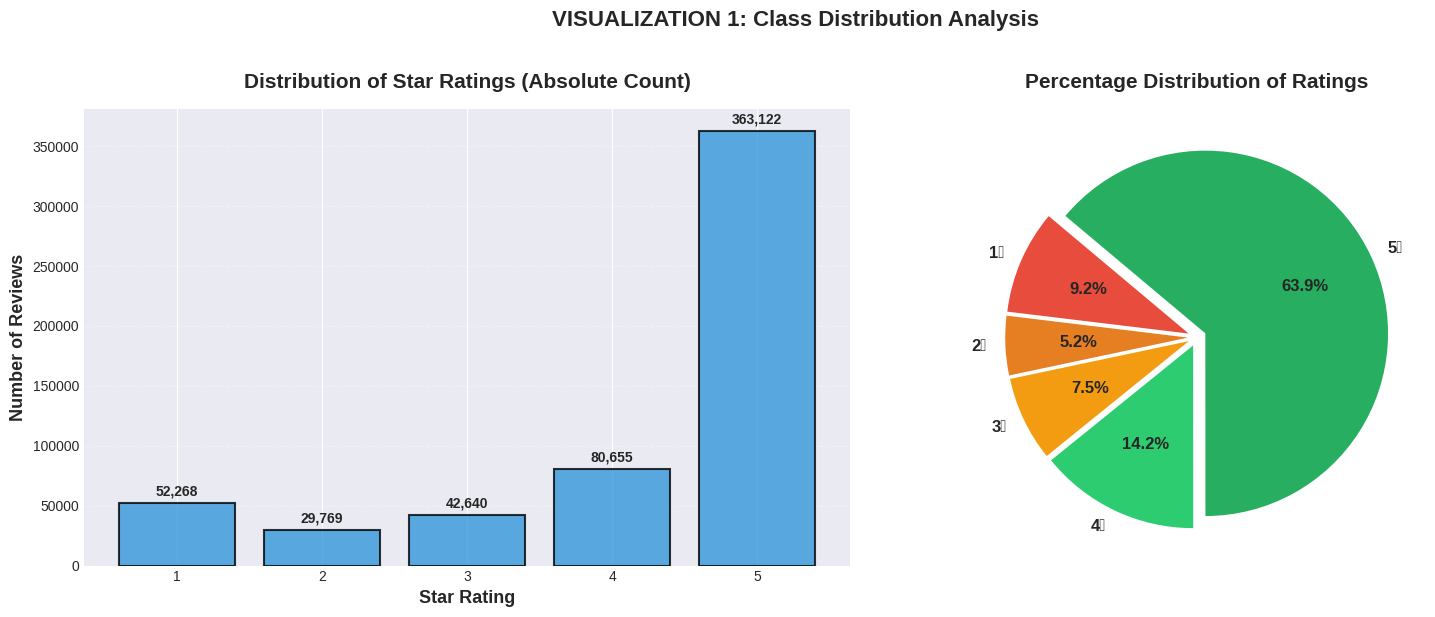

In [22]:
# VISUALIZATION

print("EXPLORATORY DATA ANALYSIS")

print("\nVISUALIZATION 1: Target Variable Distribution (Class Balance)")

# Calculate distribution
score_distribution = df['Score'].value_counts().sort_index()

print("\nRating Distribution:")
for rating, count in score_distribution.items():
    percentage = (count / len(df)) * 100
    bar_visual = '█' * int(percentage / 2)
    print(f"  {rating}★ │ {count:>8,} reviews ({percentage:5.2f}%) {bar_visual}")

print(f"\nTotal Reviews: {len(df):,}")

# Calculate class imbalance
max_class = score_distribution.max()
min_class = score_distribution.min()
imbalance_ratio = max_class / min_class

print(f"\  Class Imbalance Analysis:")
print(f"  Majority Class (5★): {max_class:,} samples")
print(f"  Minority Class (1★): {min_class:,} samples")
print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
axes[0].bar(score_distribution.index, score_distribution.values,
            color='#3498DB', edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0].set_xlabel('Star Rating', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Reviews', fontsize=13, fontweight='bold')
axes[0].set_title('Distribution of Star Ratings (Absolute Count)',
                  fontsize=15, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_xticks([1, 2, 3, 4, 5])

# Add count labels
for rating, count in score_distribution.items():
    axes[0].text(rating, count + max(score_distribution.values) * 0.01,
                f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Pie chart
colors = ['#E74C3C', '#E67E22', '#F39C12', '#2ECC71', '#27AE60']
explode = (0.05, 0.05, 0.05, 0.05, 0.05)
axes[1].pie(score_distribution.values,
           labels=[f'{s}★' for s in score_distribution.index],
           autopct='%1.1f%%',
           colors=colors,
           explode=explode,
           startangle=140,
           textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Percentage Distribution of Ratings',
                 fontsize=15, fontweight='bold', pad=15)

plt.suptitle('VISUALIZATION 1: Class Distribution Analysis',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



VISUALIZATION 2: Text Length Characteristics

Review Text Statistics:
count    568454.00
mean         80.26
std          79.46
min           3.00
25%          33.00
50%          56.00
75%          98.00
max        3432.00
Name: text_word_count, dtype: float64

Summary Statistics:
count    568454.00
mean          4.11
std           2.60
min           0.00
25%           2.00
50%           4.00
75%           5.00
max          42.00
Name: summary_word_count, dtype: float64


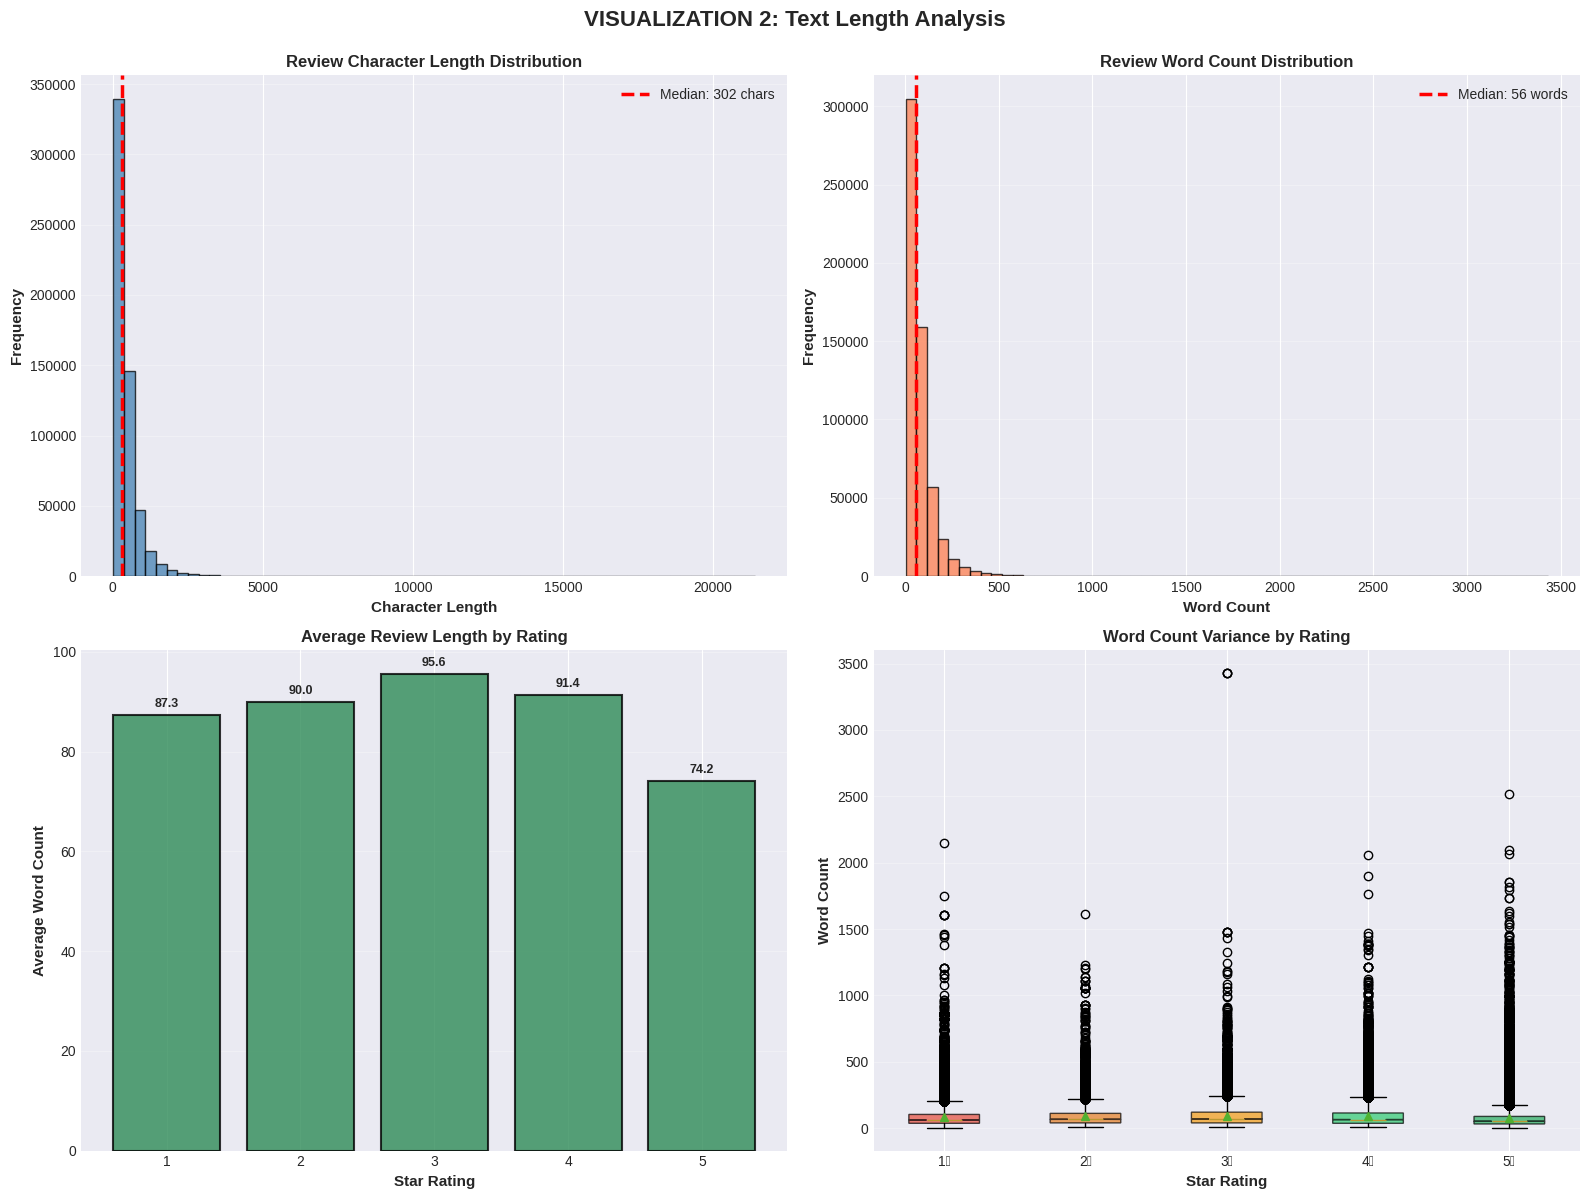

In [23]:
# TEXT LENGTH ANALYSIS

print("VISUALIZATION 2: Text Length Characteristics")


# Create text length features
df['text_char_length'] = df['Text'].fillna('').apply(len)
df['text_word_count'] = df['Text'].fillna('').apply(lambda x: len(x.split()))
df['summary_char_length'] = df['Summary'].fillna('').apply(len)
df['summary_word_count'] = df['Summary'].fillna('').apply(lambda x: len(x.split()))

print("\nReview Text Statistics:")
print(df['text_word_count'].describe().round(2))

print("\nSummary Statistics:")
print(df['summary_word_count'].describe().round(2))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Review character length distribution
axes[0, 0].hist(df['text_char_length'], bins=60, edgecolor='black',
                alpha=0.75, color='steelblue')
median_char = df['text_char_length'].median()
axes[0, 0].axvline(median_char, color='red', linestyle='--', linewidth=2.5,
                   label=f'Median: {median_char:.0f} chars')
axes[0, 0].set_xlabel('Character Length', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Review Character Length Distribution', fontweight='bold', fontsize=12)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# Review word count distribution
axes[0, 1].hist(df['text_word_count'], bins=60, edgecolor='black',
                alpha=0.75, color='coral')
median_words = df['text_word_count'].median()
axes[0, 1].axvline(median_words, color='red', linestyle='--', linewidth=2.5,
                   label=f'Median: {median_words:.0f} words')
axes[0, 1].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Review Word Count Distribution', fontweight='bold', fontsize=12)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)

# Average word count by rating
avg_words_by_rating = df.groupby('Score')['text_word_count'].mean().sort_index()
axes[1, 0].bar(avg_words_by_rating.index, avg_words_by_rating.values,
               color='seagreen', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xlabel('Star Rating', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Average Word Count', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Average Review Length by Rating', fontweight='bold', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_xticks([1, 2, 3, 4, 5])

# Add value labels
for rating, avg_words in avg_words_by_rating.items():
    axes[1, 0].text(rating, avg_words + 1, f'{avg_words:.1f}',
                   ha='center', va='bottom', fontweight='bold', fontsize=9)

# Box plot: word count variance by rating
colors_box = ['#E74C3C', '#E67E22', '#F39C12', '#2ECC71', '#27AE60']
bp = axes[1, 1].boxplot([df[df['Score'] == i]['text_word_count'].values for i in range(1, 6)],
                         labels=['1★', '2★', '3★', '4★', '5★'],
                         patch_artist=True,
                         notch=True,
                         showmeans=True)

for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 1].set_xlabel('Star Rating', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Word Count', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Word Count Variance by Rating', fontweight='bold', fontsize=12)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('VISUALIZATION 2: Text Length Analysis',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()



VISUALIZATION 3: Temporal Distribution of Reviews

Review Period: 1999-10-08 to 2012-10-26
Time Span: 4767 days
          (13.1 years)


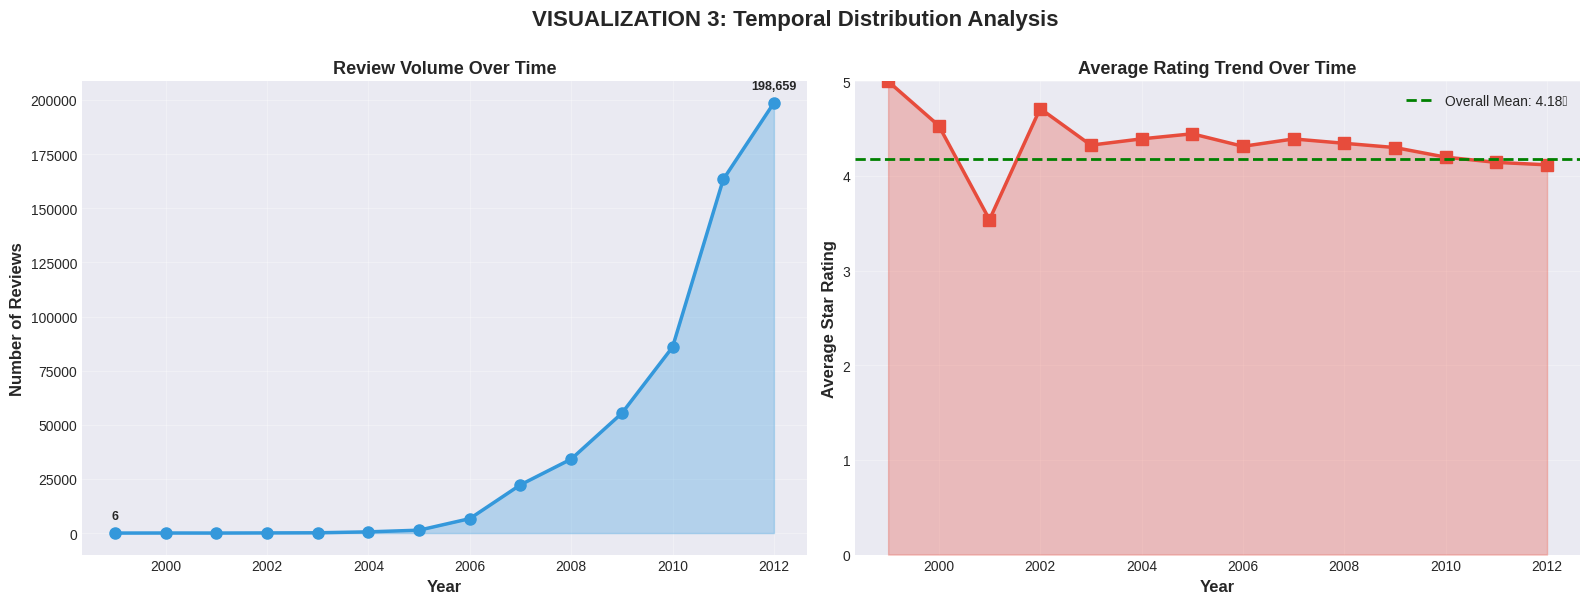

In [24]:
# TEMPORAL DISTRIBUTION ANALYSIS

print("VISUALIZATION 3: Temporal Distribution of Reviews")

# Convert Unix timestamp to datetime
df['review_date'] = pd.to_datetime(df['Time'], unit='s')
df['year'] = df['review_date'].dt.year
df['month'] = df['review_date'].dt.month

print(f"\nReview Period: {df['review_date'].min().date()} to {df['review_date'].max().date()}")
print(f"Time Span: {(df['review_date'].max() - df['review_date'].min()).days} days")
print(f"          ({(df['review_date'].max() - df['review_date'].min()).days / 365.25:.1f} years)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Reviews over time
reviews_by_year = df.groupby('year').size()
axes[0].plot(reviews_by_year.index, reviews_by_year.values,
            marker='o', linewidth=2.5, markersize=8, color='#3498DB')
axes[0].fill_between(reviews_by_year.index, reviews_by_year.values, alpha=0.3, color='#3498DB')
axes[0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Reviews', fontsize=12, fontweight='bold')
axes[0].set_title('Review Volume Over Time', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add value labels for peaks
for year, count in reviews_by_year.items():
    if count == reviews_by_year.max() or count == reviews_by_year.min():
        axes[0].annotate(f'{count:,}', xy=(year, count),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', fontweight='bold', fontsize=9)

# Average rating over time
avg_rating_by_year = df.groupby('year')['Score'].mean()
axes[1].plot(avg_rating_by_year.index, avg_rating_by_year.values,
            marker='s', linewidth=2.5, markersize=8, color='#E74C3C')
axes[1].fill_between(avg_rating_by_year.index, avg_rating_by_year.values,
                     alpha=0.3, color='#E74C3C')
axes[1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Star Rating', fontsize=12, fontweight='bold')
axes[1].set_title('Average Rating Trend Over Time', fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 5])
axes[1].grid(True, alpha=0.3)

# Add horizontal line for overall mean
overall_mean = df['Score'].mean()
axes[1].axhline(overall_mean, color='green', linestyle='--', linewidth=2,
               label=f'Overall Mean: {overall_mean:.2f}★')
axes[1].legend(fontsize=10)

plt.suptitle('VISUALIZATION 3: Temporal Distribution Analysis',
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


VISUALIZATION 4: Vocabulary Richness Analysis

Vocabulary Statistics:
       unique_words  lexical_diversity
count   568454.0000        568454.0000
mean        58.5026             0.8057
std         44.2624             0.1044
min          3.0000             0.1026
25%         29.0000             0.7333
50%         46.0000             0.8108
75%         73.0000             0.8846
max       1205.0000             1.0000


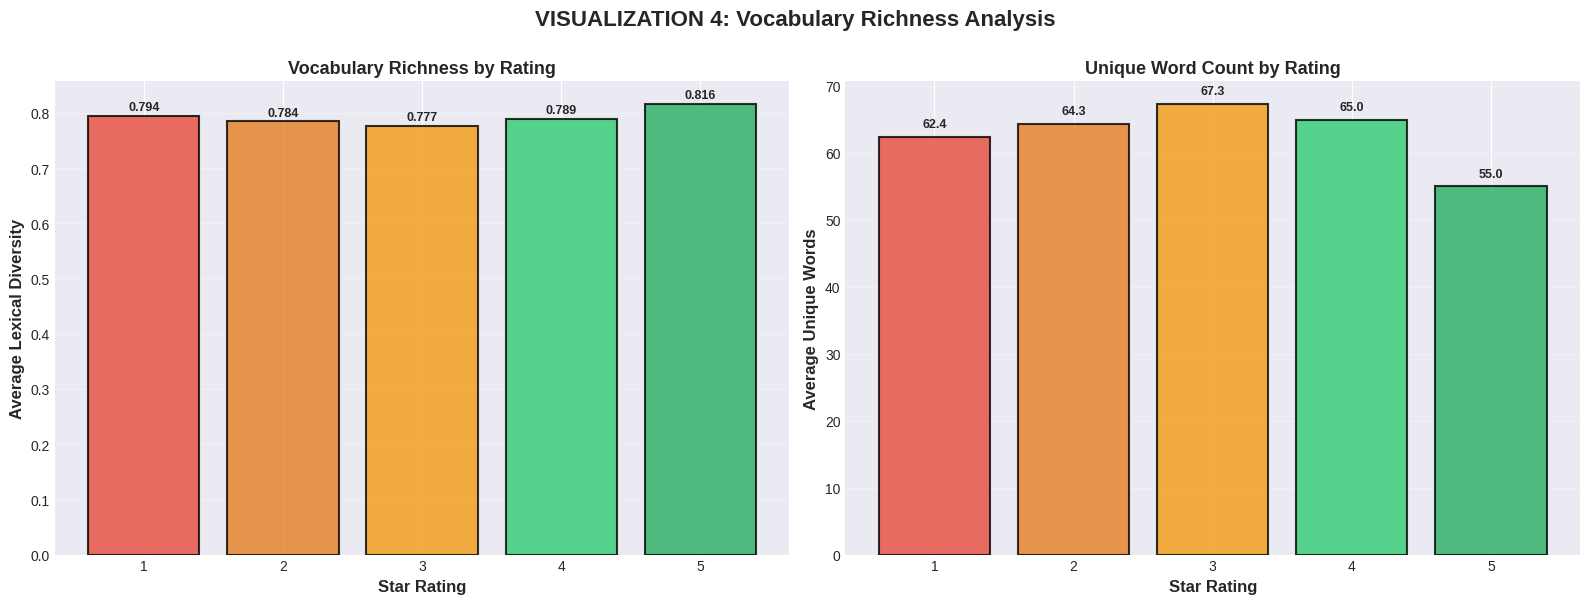

In [25]:
# VOCABULARY RICHNESS ANALYSIS

print("VISUALIZATION 4: Vocabulary Richness Analysis")

# Calculate unique words per review
df['unique_words'] = df['Text'].fillna('').apply(lambda x: len(set(x.lower().split())))
df['lexical_diversity'] = df['unique_words'] / df['text_word_count'].replace(0, 1)

print("\nVocabulary Statistics:")
print(df[['unique_words', 'lexical_diversity']].describe().round(4))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Lexical diversity by rating
diversity_by_rating = df.groupby('Score')['lexical_diversity'].mean()
colors = ['#E74C3C', '#E67E22', '#F39C12', '#2ECC71', '#27AE60']

axes[0].bar(diversity_by_rating.index, diversity_by_rating.values,
           color=colors,
           edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0].set_xlabel('Star Rating', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Lexical Diversity', fontsize=12, fontweight='bold')
axes[0].set_title('Vocabulary Richness by Rating', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticks([1, 2, 3, 4, 5])

# Add value labels
for rating, diversity in diversity_by_rating.items():
    axes[0].text(rating, diversity + 0.005, f'{diversity:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

# Unique words by rating
unique_words_by_rating = df.groupby('Score')['unique_words'].mean()
axes[1].bar(unique_words_by_rating.index, unique_words_by_rating.values,
           color=colors,
           edgecolor='black', linewidth=1.5, alpha=0.8)
axes[1].set_xlabel('Star Rating', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Unique Words', fontsize=12, fontweight='bold')
axes[1].set_title('Unique Word Count by Rating', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticks([1, 2, 3, 4, 5])

# Add value labels
for rating, unique_count in unique_words_by_rating.items():
    axes[1].text(rating, unique_count + 1, f'{unique_count:.1f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.suptitle('VISUALIZATION 4: Vocabulary Richness Analysis',
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


 Most Frequent Words by Rating Category


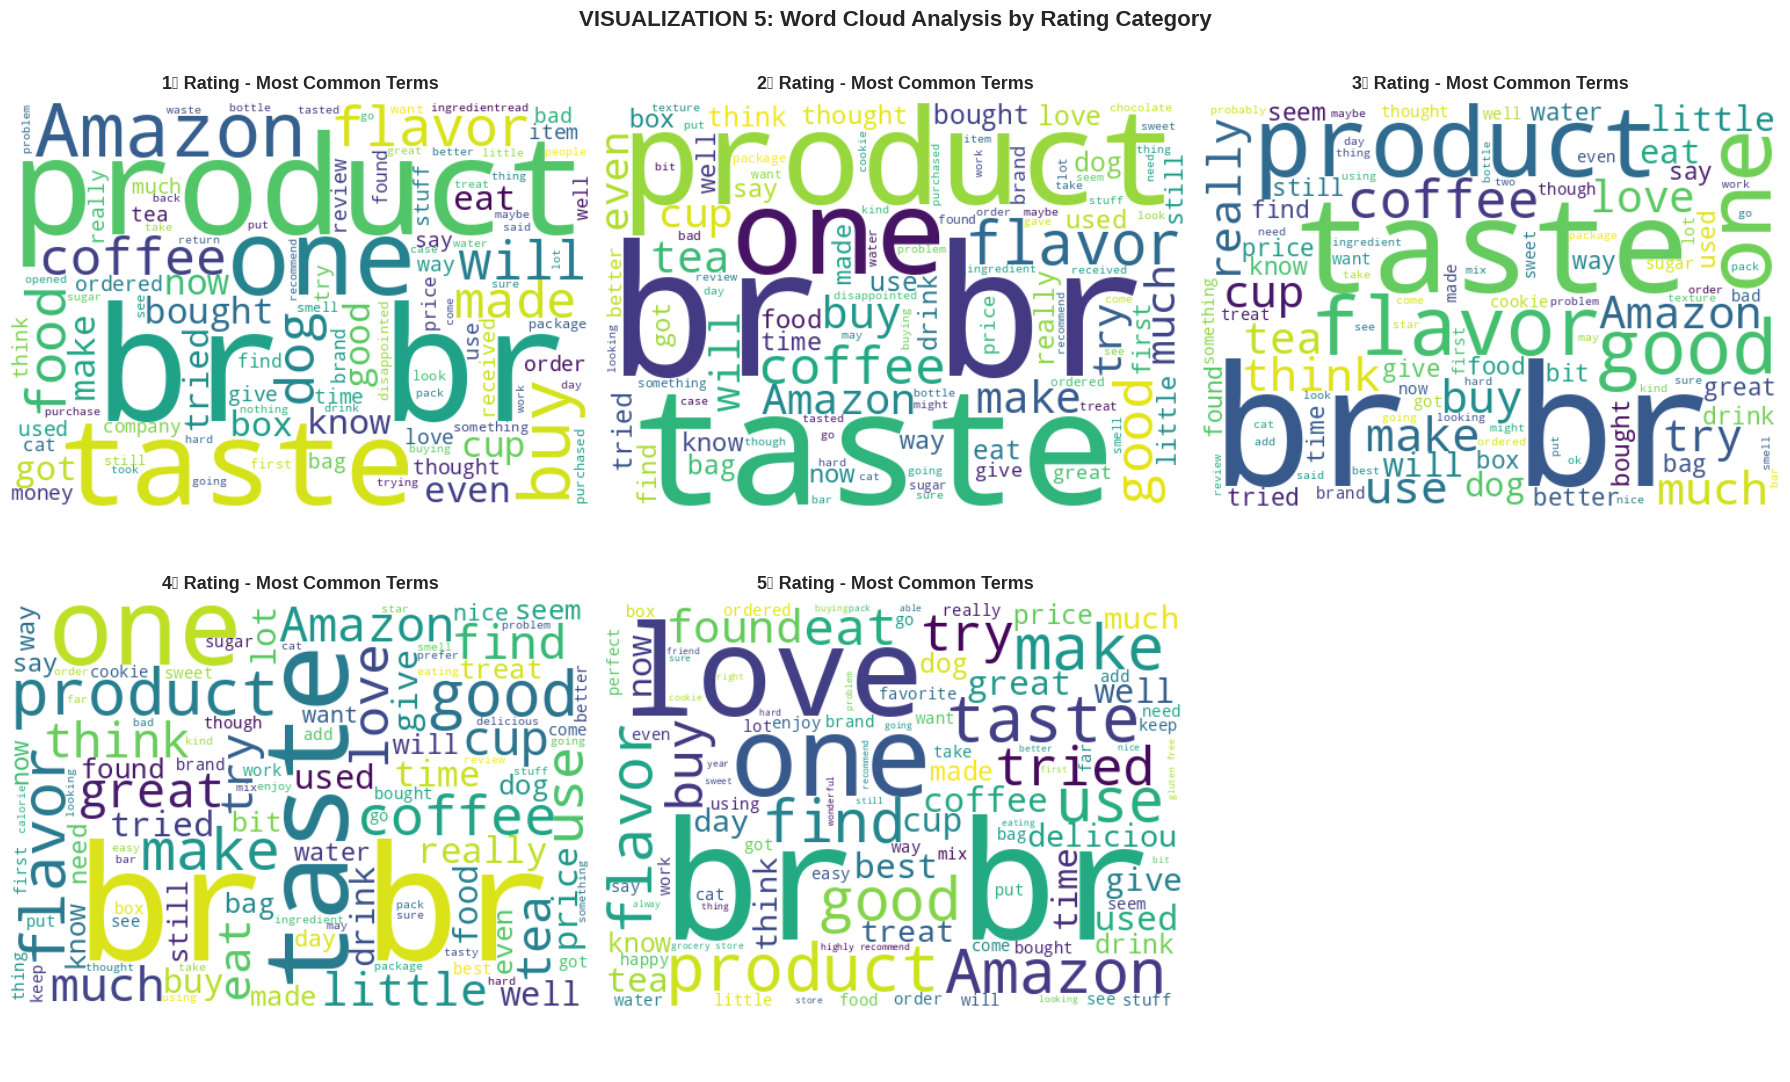

In [26]:
# WORD CLOUD ANALYSIS BY RATING

print(" Most Frequent Words by Rating Category")


fig, axes = plt.subplots(2, 3, figsize=(18, 11))
axes = axes.flatten()

for idx, rating in enumerate([1, 2, 3, 4, 5]):
    # Combining all text for this rating
    rating_text = ' '.join(df[df['Score'] == rating]['Text'].fillna('').values)

    # Generating word cloud
    wordcloud = WordCloud(
        width=500,
        height=350,
        background_color='white',
        colormap='viridis',
        max_words=100,
        relative_scaling=0.5,
        min_font_size=8
    ).generate(rating_text)

    # Display
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{rating}★ Rating - Most Common Terms',
                       fontsize=13, fontweight='bold', pad=10)
    axes[idx].axis('off')

# Removing extra subplot
axes[5].axis('off')

plt.suptitle('VISUALIZATION 5: Word Cloud Analysis by Rating Category',
            fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


In [27]:
# TEXT PREPROCESSING PIPELINE SETUP


import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from tqdm import tqdm


print("TEXT PREPROCESSING PIPELINE")

# Download NLTK resources
print("\nDownloading NLTK resources...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('omw-1.4', quiet=True)
print(" NLTK resources ready")


print("PREPROCESSING PIPELINE STEPS:")

def preprocess_text(text):

    if pd.isna(text):
        return ""

    # Remove HTML tags
    text = BeautifulSoup(str(text), "html.parser").get_text()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Lowercase conversion
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) >= 2]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

print("\nPreprocessing function defined and ready")


TEXT PREPROCESSING PIPELINE

 NLTK resources ready
PREPROCESSING PIPELINE STEPS:

Preprocessing function defined and ready


In [28]:
# APPLY PREPROCESSING TO DATASET

print("APPLYING PREPROCESSING TO ALL REVIEWS")

print("\nProcessing reviews (this may take a few minutes)...")

# Applying preprocessing with progress bar
df['cleaned_text'] = [preprocess_text(text) for text in tqdm(df['Text'], desc="Cleaning")]

# Removing empty texts
original_count = len(df)
df = df[df['cleaned_text'].str.len() > 0].reset_index(drop=True)
removed_count = original_count - len(df)

print(f"\ Preprocessing complete")
print(f"  Processed: {len(df):,} reviews")
print(f"  Removed: {removed_count:,} empty reviews after cleaning")
print(f"  Retention rate: {(len(df)/original_count)*100:.2f}%")

# Showing transformation examples

print("PREPROCESSING EXAMPLES")

for i in [100, 200, 300]:
    print(f"\nExample {i//100}:")
    print("-" * 80)
    print("ORIGINAL TEXT:")
    print(df['Text'].iloc[i][:250] + "...")
    print("\nCLEANED TEXT:")
    print(df['cleaned_text'].iloc[i][:250] + "...")



APPLYING PREPROCESSING TO ALL REVIEWS

Processing reviews (this may take a few minutes)...


Cleaning: 100%|██████████| 568454/568454 [09:06<00:00, 1039.87it/s]


\ Preprocessing complete
  Processed: 568,446 reviews
  Removed: 8 empty reviews after cleaning
  Retention rate: 100.00%
PREPROCESSING EXAMPLES

Example 1:
--------------------------------------------------------------------------------
ORIGINAL TEXT:
The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy....

CLEANED TEXT:
mouth say love thee let count waysif like apple product must item draw back shipping cost heavy...

Example 2:
--------------------------------------------------------------------------------
ORIGINAL TEXT:
Even with small containers, they don't fill them up.  These little tins are less than half filled and at the price charged it seems a rip-off. Is there some exotic ingredient as costly as gold contained in those tiny squares?  Or how about the cereal...

CLEANED TEXT:
even small container dont fill little tin less half filled price charged seems ri

In [29]:
# TRAIN-TEST SPLIT WITH STRATIFICATION


from sklearn.model_selection import train_test_split

print("TRAIN-TEST SPLIT STRATEGY")

# Preparing features and labels
X = df['cleaned_text'].values
y = df['Score'].values - 1

print("\nSplit Configuration:")
print("  Split Ratio: 80% Training / 20% Testing")
print("  Stratification: Enabled (maintains class distribution)")
print("  Random State: 42 (for reproducibility)")

# Performing stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nSplit Results:")
print(f"  Training Set:   {len(X_train):>8,} samples ({len(X_train)/len(df)*100:>5.2f}%)")
print(f"  Test Set:       {len(X_test):>8,} samples ({len(X_test)/len(df)*100:>5.2f}%)")
print(f"  Total:          {len(df):>8,} samples")

# Verifying stratification
print("\nClass Distribution Verification:")
print(f"{'Class':<15} {'Train Count':<15} {'Train %':<12} {'Test Count':<15} {'Test %'}")

for cls in range(5):
    train_count = np.sum(y_train == cls)
    test_count = np.sum(y_test == cls)
    train_pct = (train_count / len(y_train)) * 100
    test_pct = (test_count / len(y_test)) * 100
    print(f"{cls+1}★ (Class {cls})   {train_count:<15,} {train_pct:<12.2f} "
          f"{test_count:<15,} {test_pct:.2f}")

TRAIN-TEST SPLIT STRATEGY

Split Configuration:
  Split Ratio: 80% Training / 20% Testing
  Stratification: Enabled (maintains class distribution)
  Random State: 42 (for reproducibility)

Split Results:
  Training Set:    454,756 samples (80.00%)
  Test Set:        113,690 samples (20.00%)
  Total:           568,446 samples

Class Distribution Verification:
Class           Train Count     Train %      Test Count      Test %
1★ (Class 0)   41,814          9.19         10,454          9.20
2★ (Class 1)   23,815          5.24         5,954           5.24
3★ (Class 2)   34,112          7.50         8,528           7.50
4★ (Class 3)   64,524          14.19        16,131          14.19
5★ (Class 4)   290,491         63.88        72,623          63.88


In [30]:
# CROSS-VALIDATION STRATEGY SETUP


from sklearn.model_selection import StratifiedKFold
print("CROSS-VALIDATION STRATEGY")
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



CROSS-VALIDATION STRATEGY


In [31]:
# TF-IDF VECTORIZATION


from sklearn.feature_extraction.text import TfidfVectorizer
import time

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

print("Fitting vectorizer on training data...")

# Fit and transform
start_time = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
vectorization_time = time.time() - start_time

print(f"\n Vectorization complete in {vectorization_time:.2f} seconds")

print("\nTF-IDF Statistics:")
print(f"  Vocabulary Size:      {len(tfidf_vectorizer.vocabulary_):>8,} unique terms")
print(f"  Feature Dimensions:   {X_train_tfidf.shape[1]:>8,}")
print(f"  Training Matrix:      {X_train_tfidf.shape}")
print(f"  Test Matrix:          {X_test_tfidf.shape}")

# Calculating sparsity
sparsity = (1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100
print(f"  Matrix Sparsity:      {sparsity:>8.2f}%")

# Showing sample features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample Features (first 30):")
print(f"  Unigrams: {list(feature_names[:15])}")
print(f"  Bigrams:  {list(feature_names[2500:2515])}")

Fitting vectorizer on training data...

 Vectorization complete in 58.68 seconds

TF-IDF Statistics:
  Vocabulary Size:         5,000 unique terms
  Feature Dimensions:      5,000
  Training Matrix:      (454756, 5000)
  Test Matrix:          (113690, 5000)
  Matrix Sparsity:         99.33%

Sample Features (first 30):
  Unigrams: ['ability', 'able', 'able buy', 'able find', 'able get', 'absolute', 'absolute favorite', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loved', 'absorb', 'acai', 'acceptable', 'access']
  Bigrams:  ['like chocolate', 'like coconut', 'like coffee', 'like dark', 'like dog', 'like dont', 'like drink', 'like drinking', 'like eat', 'like eating', 'like fact', 'like flavor', 'like flavored', 'like food', 'like fresh']


In [32]:
# LOGISTIC REGRESSION + TF-IDF WITH HYPERPARAMETER TUNING


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0]
}

# Base model
base_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)

print("\nPerforming grid search with cross-validation...")

# Grid search
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=cv_strategy,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search.fit(X_train_tfidf, y_train)
tuning_time = time.time() - start_time

print(f"\n Hyperparameter tuning completed in {tuning_time:.2f} seconds")

# Display results
print("GRID SEARCH RESULTS")

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score (Macro): {grid_search.best_score_:.4f}")

# Detailed CV results
cv_results = grid_search.cv_results_
print("\nDetailed Cross-Validation Results:")
print(f"{'C Parameter':<15} {'Mean CV F1':<15} {'Std CV F1':<15} {'Mean Train F1':<15}")

for i, params in enumerate(cv_results['params']):
    mean_test = cv_results['mean_test_score'][i]
    std_test = cv_results['std_test_score'][i]
    mean_train = cv_results['mean_train_score'][i]
    print(f"{params['C']:<15} {mean_test:<15.4f} {std_test:<15.4f} {mean_train:<15.4f}")


# Use best model
lr_tfidf_model = grid_search.best_estimator_

# Store CV score for later comparison
cv_f1_tfidf = grid_search.best_score_
cv_std_tfidf = cv_results['std_test_score'][grid_search.best_index_]

print(f"\n Best model selected: C = {lr_tfidf_model.C}")
print(f"  Cross-validated F1: {cv_f1_tfidf:.4f} (±{cv_std_tfidf:.4f})")
print("FINAL MODEL TRAINING")

# Model is already trained via grid_search, but we can access it
print(f"Using optimized model with C = {lr_tfidf_model.C}")




Performing grid search with cross-validation...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

 Hyperparameter tuning completed in 726.50 seconds
GRID SEARCH RESULTS

Best Parameters: {'C': 1.0}
Best CV F1-Score (Macro): 0.5110

Detailed Cross-Validation Results:
C Parameter     Mean CV F1      Std CV F1       Mean Train F1  
0.1             0.5038          0.0006          0.5297         
1.0             0.5110          0.0023          0.5511         
10.0            0.5090          0.0020          0.5539         

 Best model selected: C = 1.0
  Cross-validated F1: 0.5110 (±0.0023)
FINAL MODEL TRAINING
Using optimized model with C = 1.0


MODEL EVALUATION: LOGISTIC REGRESSION + TF-IDF

Generating predictions on test set...
 Predictions generated
OVERALL PERFORMANCE METRICS

Test Set Performance:
  Accuracy:                    0.6461

  Macro-Averaged Metrics (treats all classes equally):
    Precision:                 0.4911
    Recall:                    0.5668
    F1-Score:                  0.5162

  Weighted-Averaged Metrics (accounts for class imbalance):
    Precision:                 0.7233
    Recall:                    0.6461
    F1-Score:                  0.6726
PER-CLASS PERFORMANCE BREAKDOWN

Rating       Precision    Recall       F1-Score     Support   
1★ (Class 0)  0.5745       0.6842       0.6246       10,454    
2★ (Class 1)  0.2952       0.4782       0.3651       5,954     
3★ (Class 2)  0.3272       0.4719       0.3864       8,528     
4★ (Class 3)  0.3491       0.4901       0.4077       16,131    
5★ (Class 4)  0.9095       0.7095       0.7971       72,623    
CONFUSION MATRIX

Rows = Actual, Columns 

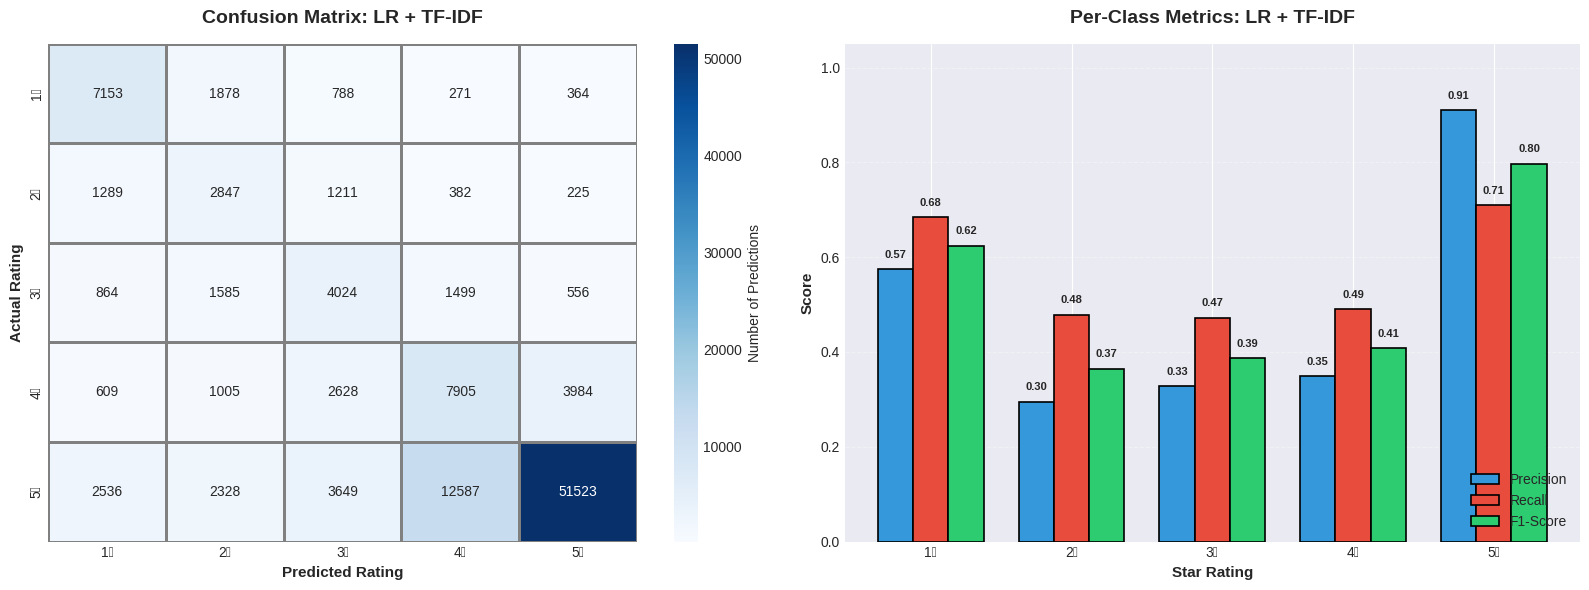

In [33]:
# EVALUATION - LOGISTIC REGRESSION + TF-IDF


from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

print("MODEL EVALUATION: LOGISTIC REGRESSION + TF-IDF")

# Generate predictions
print("\nGenerating predictions on test set...")
y_pred_tfidf = lr_tfidf_model.predict(X_test_tfidf)
y_pred_proba_tfidf = lr_tfidf_model.predict_proba(X_test_tfidf)
print(" Predictions generated")

# Calculate metrics
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

precision_tfidf, recall_tfidf, f1_tfidf, support_tfidf = precision_recall_fscore_support(
    y_test, y_pred_tfidf, average=None, zero_division=0
)

precision_macro_tfidf, recall_macro_tfidf, f1_macro_tfidf, _ = precision_recall_fscore_support(
    y_test, y_pred_tfidf, average='macro', zero_division=0
)

precision_weighted_tfidf, recall_weighted_tfidf, f1_weighted_tfidf, _ = precision_recall_fscore_support(
    y_test, y_pred_tfidf, average='weighted', zero_division=0
)

# Display overall metrics
print("OVERALL PERFORMANCE METRICS")

print(f"\nTest Set Performance:")
print(f"  Accuracy:                    {accuracy_tfidf:.4f}")
print(f"\n  Macro-Averaged Metrics (treats all classes equally):")
print(f"    Precision:                 {precision_macro_tfidf:.4f}")
print(f"    Recall:                    {recall_macro_tfidf:.4f}")
print(f"    F1-Score:                  {f1_macro_tfidf:.4f}")
print(f"\n  Weighted-Averaged Metrics (accounts for class imbalance):")
print(f"    Precision:                 {precision_weighted_tfidf:.4f}")
print(f"    Recall:                    {recall_weighted_tfidf:.4f}")
print(f"    F1-Score:                  {f1_weighted_tfidf:.4f}")

# Per-class metrics
print("PER-CLASS PERFORMANCE BREAKDOWN")

print(f"\n{'Rating':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
for i in range(5):
    print(f"{i+1}★ (Class {i})  {precision_tfidf[i]:<12.4f} {recall_tfidf[i]:<12.4f} "
          f"{f1_tfidf[i]:<12.4f} {support_tfidf[i]:<10,.0f}")

# Confusion Matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

print("CONFUSION MATRIX")
print("\nRows = Actual, Columns = Predicted")
print(cm_tfidf)

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix heatmap
sns.heatmap(
    cm_tfidf,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['1★', '2★', '3★', '4★', '5★'],
    yticklabels=['1★', '2★', '3★', '4★', '5★'],
    cbar_kws={'label': 'Number of Predictions'},
    linewidths=1,
    linecolor='gray',
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix: LR + TF-IDF',
                 fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Predicted Rating', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Actual Rating', fontsize=11, fontweight='bold')

# Per-class metrics bar chart
x = np.arange(5)
width = 0.25

axes[1].bar(x - width, precision_tfidf, width, label='Precision',
           color='#3498DB', edgecolor='black', linewidth=1.2)
axes[1].bar(x, recall_tfidf, width, label='Recall',
           color='#E74C3C', edgecolor='black', linewidth=1.2)
axes[1].bar(x + width, f1_tfidf, width, label='F1-Score',
           color='#2ECC71', edgecolor='black', linewidth=1.2)

axes[1].set_xlabel('Star Rating', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[1].set_title('Per-Class Metrics: LR + TF-IDF', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['1★', '2★', '3★', '4★', '5★'])
axes[1].legend(fontsize=10, loc='lower right')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim([0, 1.05])

# Add value labels
for i in range(5):
    if precision_tfidf[i] > 0.05:
        axes[1].text(i - width, precision_tfidf[i] + 0.02, f'{precision_tfidf[i]:.2f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    if recall_tfidf[i] > 0.05:
        axes[1].text(i, recall_tfidf[i] + 0.02, f'{recall_tfidf[i]:.2f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    if f1_tfidf[i] > 0.05:
        axes[1].text(i + width, f1_tfidf[i] + 0.02, f'{f1_tfidf[i]:.2f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [34]:
# ERROR ANALYSIS - TF-IDF MODEL


print("UNDERSTANDING MISCLASSIFICATIONS")

# Find misclassified examples
misclassified_idx = np.where(y_test != y_pred_tfidf)[0]
correct_idx = np.where(y_test == y_pred_tfidf)[0]

print(f"\nMisclassification Summary:")
print(f"  Total misclassifications: {len(misclassified_idx):,} ({len(misclassified_idx)/len(y_test)*100:.2f}%)")
print(f"  Correctly classified: {len(correct_idx):,} ({len(correct_idx)/len(y_test)*100:.2f}%)")

# Analyze error patterns
print("MOST COMMON ERROR PATTERNS")

error_df = pd.DataFrame({
    'True_Rating': y_test[misclassified_idx] + 1,
    'Predicted_Rating': y_pred_tfidf[misclassified_idx] + 1
})

error_patterns = error_df.groupby(['True_Rating', 'Predicted_Rating']).size().reset_index(name='Count')
error_patterns = error_patterns.sort_values('Count', ascending=False).head(10)

print(f"\n{'True Rating':<15} {'Predicted As':<15} {'Occurrences':<15} {'% of Errors'}")
for _, row in error_patterns.iterrows():
    pct = (row['Count'] / len(misclassified_idx)) * 100
    print(f"{row['True_Rating']}★{'':<13} {row['Predicted_Rating']}★{'':<13} "
          f"{row['Count']:<15,} {pct:.2f}%")

# Confidence analysis
print("PREDICTION CONFIDENCE ANALYSIS")

max_probs = np.max(y_pred_proba_tfidf, axis=1)

print(f"\nAverage Prediction Confidence:")
print(f"  Correct predictions:    {max_probs[correct_idx].mean():.4f}")
print(f"  Incorrect predictions:  {max_probs[misclassified_idx].mean():.4f}")
print(f"  Difference:             {max_probs[correct_idx].mean() - max_probs[misclassified_idx].mean():.4f}")

print(f"\nConfidence Distribution:")
print(f"  Correct - Min: {max_probs[correct_idx].min():.4f}, Max: {max_probs[correct_idx].max():.4f}")
print(f"  Incorrect - Min: {max_probs[misclassified_idx].min():.4f}, Max: {max_probs[misclassified_idx].max():.4f}")

# Show example misclassifications
print("EXAMPLE MISCLASSIFICATIONS")

num_examples = min(5, len(misclassified_idx))
sample_errors = np.random.choice(misclassified_idx, num_examples, replace=False)

for i, idx in enumerate(sample_errors, 1):
    true_rating = y_test[idx] + 1
    pred_rating = y_pred_tfidf[idx] + 1
    confidence = y_pred_proba_tfidf[idx][y_pred_tfidf[idx]]

    print(f"\nExample {i}:")
    print(f"  True Rating: {true_rating}★ | Predicted: {pred_rating}★ (Confidence: {confidence:.2f})")
    print(f"  Review Text: {X_test[idx][:200]}...")


# Confusion by rating distance
print("ERROR DISTANCE ANALYSIS")

rating_distances = np.abs(y_test[misclassified_idx] - y_pred_tfidf[misclassified_idx])
distance_counts = pd.Series(rating_distances).value_counts().sort_index()

print(f"\n{'Distance':<15} {'Count':<15} {'% of Errors'}")
for distance, count in distance_counts.items():
    pct = (count / len(misclassified_idx)) * 100
    print(f"{distance} star(s){'':<7} {count:<15,} {pct:.2f}%")


UNDERSTANDING MISCLASSIFICATIONS

Misclassification Summary:
  Total misclassifications: 40,238 (35.39%)
  Correctly classified: 73,452 (64.61%)
MOST COMMON ERROR PATTERNS

True Rating     Predicted As    Occurrences     % of Errors
5★              4★              12,587          31.28%
4★              5★              3,984           9.90%
5★              3★              3,649           9.07%
4★              3★              2,628           6.53%
5★              1★              2,536           6.30%
5★              2★              2,328           5.79%
1★              2★              1,878           4.67%
3★              2★              1,585           3.94%
3★              4★              1,499           3.73%
2★              1★              1,289           3.20%
PREDICTION CONFIDENCE ANALYSIS

Average Prediction Confidence:
  Correct predictions:    0.6619
  Incorrect predictions:  0.4945
  Difference:             0.1674

Confidence Distribution:
  Correct - Min: 0.2180, Max: 0.9996
 

In [35]:
#: EMBEDDING 2 - WORD2VEC SKIP-GRAM


from gensim.models import Word2Vec


print("EMBEDDING 2: WORD2VEC SKIP-GRAM")


print("PREPARING DATA FOR WORD2VEC")

# Tokenize texts for Word2Vec (needs list of word lists)
train_sentences = [text.split() for text in X_train]
test_sentences = [text.split() for text in X_test]

print(f"  Training sentences: {len(train_sentences):,}")
print(f"  Test sentences: {len(test_sentences):,}")
print(f"  Sample sentence: {train_sentences[0][:15]}...")


print("TRAINING SKIP-GRAM MODEL")

start_time = time.time()
skipgram_model = Word2Vec(
    sentences=train_sentences,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,  # Skip-gram
    workers=4,
    epochs=10,
    seed=42
)
training_time = time.time() - start_time

print(f"\n Skip-gram training completed in {training_time:.2f} seconds")
print(f"\n  Vocabulary size: {len(skipgram_model.wv):,} unique words")
print(f"  Vector dimension: {skipgram_model.wv.vector_size}")
print(f"  Total training examples: {skipgram_model.corpus_total_words:,}")

# Show some word similarities
print(f"\nExample Word Similarities (cosine similarity):")
test_words = ['good', 'great', 'bad', 'delicious', 'terrible']
for word in test_words:
    if word in skipgram_model.wv:
        similar = skipgram_model.wv.most_similar(word, topn=3)
        print(f"  '{word}' → {[w for w, _ in similar]}")
print("CONVERTING DOCUMENTS TO VECTORS")

def document_vector(doc, model):
    vectors = [model.wv[word] for word in doc if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.wv.vector_size)
    return np.mean(vectors, axis=0)

# Convert to document vectors
X_train_skipgram = np.array([document_vector(doc, skipgram_model) for doc in train_sentences])
X_test_skipgram = np.array([document_vector(doc, skipgram_model) for doc in test_sentences])

print(f"  Training matrix shape: {X_train_skipgram.shape}")
print(f"  Test matrix shape: {X_test_skipgram.shape}")
print(f"  Memory usage: ~{X_train_skipgram.nbytes / 1024**2:.2f} MB")


EMBEDDING 2: WORD2VEC SKIP-GRAM
PREPARING DATA FOR WORD2VEC
  Training sentences: 454,756
  Test sentences: 113,690
  Sample sentence: ['purchased', 'seed', 'amazon', 'start', 'asparagus', 'bed', 'planted', 'seed', 'approximately', 'package', 'one', 'peat', 'pellet', 'placed', 'old']...
TRAINING SKIP-GRAM MODEL

 Skip-gram training completed in 1069.47 seconds

  Vocabulary size: 109,713 unique words
  Vector dimension: 100
  Total training examples: 18,177,876

Example Word Similarities (cosine similarity):
  'good' → ['great', 'decent', 'excellent']
  'great' → ['fantastic', 'excellent', 'awesome']
  'bad' → ['terrible', 'worse', 'good']
  'delicious' → ['yummy', 'tasty', 'flavorful']
  'terrible' → ['awful', 'horrible', 'disgusting']
CONVERTING DOCUMENTS TO VECTORS
  Training matrix shape: (454756, 100)
  Test matrix shape: (113690, 100)
  Memory usage: ~173.48 MB


In [36]:
# LOGISTIC REGRESSION + SKIP-GRAM WITH TUNING



print("MODEL 2: LOGISTIC REGRESSION + SKIP-GRAM EMBEDDINGS")

print("\nHyperparameter Tuning with Skip-gram Embeddings...")

# Same parameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0]
}

# Base model
base_model_skipgram = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)

# Grid search
grid_search_skipgram = GridSearchCV(
    base_model_skipgram,
    param_grid,
    cv=cv_strategy,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search_skipgram.fit(X_train_skipgram, y_train)
tuning_time = time.time() - start_time

print(f"\n✓ Hyperparameter tuning completed in {tuning_time:.2f} seconds")

# Display results80
print("GRID SEARCH RESULTS")


print(f"\nBest Parameters: {grid_search_skipgram.best_params_}")
print(f"Best CV F1-Score (Macro): {grid_search_skipgram.best_score_:.4f}")

# Detailed results
cv_results_skipgram = grid_search_skipgram.cv_results_
print("\nDetailed Cross-Validation Results:")
print(f"{'C Parameter':<15} {'Mean CV F1':<15} {'Std CV F1':<15} {'Mean Train F1':<15}")


for i, params in enumerate(cv_results_skipgram['params']):
    mean_test = cv_results_skipgram['mean_test_score'][i]
    std_test = cv_results_skipgram['std_test_score'][i]
    mean_train = cv_results_skipgram['mean_train_score'][i]
    print(f"{params['C']:<15} {mean_test:<15.4f} {std_test:<15.4f} {mean_train:<15.4f}")



# Use best model
lr_skipgram_model = grid_search_skipgram.best_estimator_

# Store CV scores
cv_f1_skipgram = grid_search_skipgram.best_score_
cv_std_skipgram = cv_results_skipgram['std_test_score'][grid_search_skipgram.best_index_]

print(f"\n Best model selected: C = {lr_skipgram_model.C}")
print(f"  Cross-validated F1: {cv_f1_skipgram:.4f} (±{cv_std_skipgram:.4f})")
print(" Model ready for evaluation")

# Generate predictions
y_pred_skipgram = lr_skipgram_model.predict(X_test_skipgram)
y_pred_proba_skipgram = lr_skipgram_model.predict_proba(X_test_skipgram)


MODEL 2: LOGISTIC REGRESSION + SKIP-GRAM EMBEDDINGS

Hyperparameter Tuning with Skip-gram Embeddings...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

✓ Hyperparameter tuning completed in 310.04 seconds
GRID SEARCH RESULTS

Best Parameters: {'C': 1.0}
Best CV F1-Score (Macro): 0.4374

Detailed Cross-Validation Results:
C Parameter     Mean CV F1      Std CV F1       Mean Train F1  
0.1             0.4372          0.0005          0.4388         
1.0             0.4374          0.0009          0.4389         
10.0            0.4373          0.0007          0.4388         

 Best model selected: C = 1.0
  Cross-validated F1: 0.4374 (±0.0009)
 Model ready for evaluation


MODEL EVALUATION: LOGISTIC REGRESSION + SKIP-GRAM
OVERALL PERFORMANCE METRICS

Test Set Performance:
  Accuracy:                    0.5816

  Macro-Averaged Metrics:
    Precision:                 0.4211
    Recall:                    0.4816
    F1-Score:                  0.4378

  Weighted-Averaged Metrics:
    Precision:                 0.6816
    Recall:                    0.5816
    F1-Score:                  0.6162
PER-CLASS PERFORMANCE BREAKDOWN

Rating       Precision    Recall       F1-Score     Support   
1★ (Class 0)  0.4894       0.6384       0.5541       10,454    
2★ (Class 1)  0.2189       0.3530       0.2703       5,954     
3★ (Class 2)  0.2358       0.3601       0.2850       8,528     
4★ (Class 3)  0.2705       0.3973       0.3218       16,131    
5★ (Class 4)  0.8909       0.6592       0.7577       72,623    


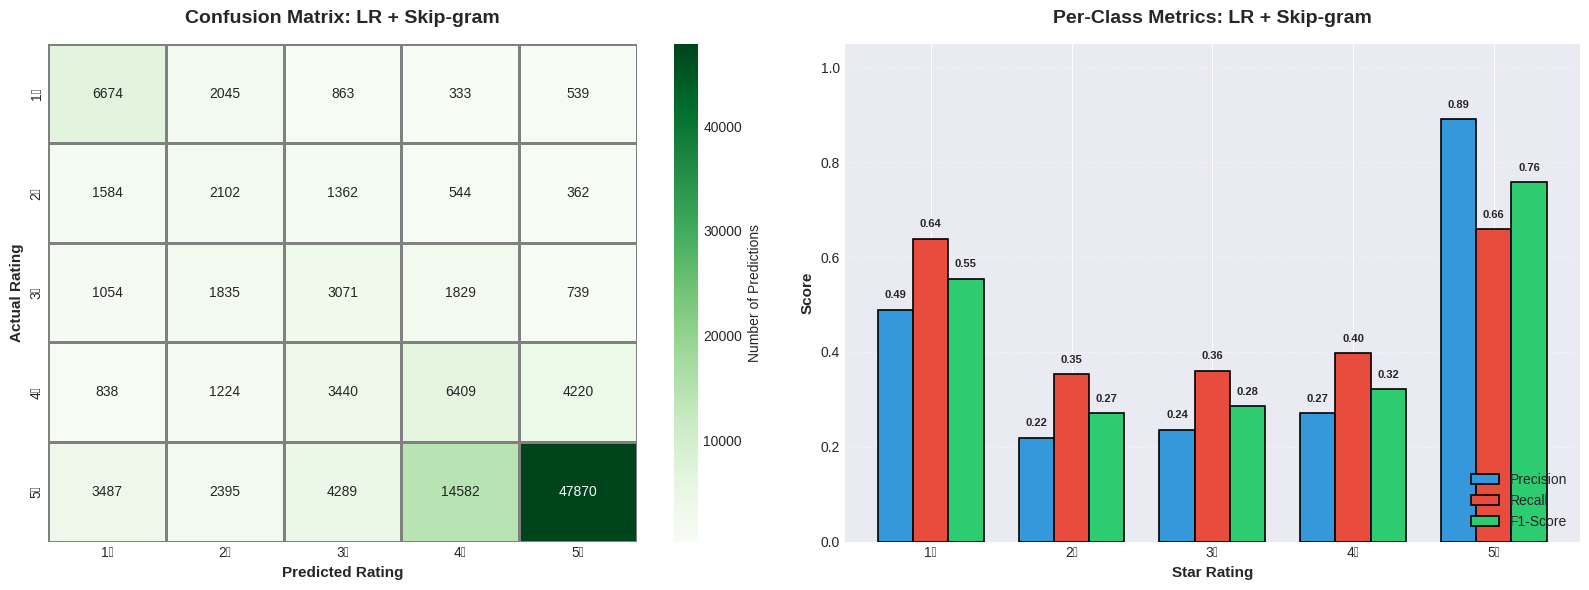

In [39]:
# EVALUATION - LOGISTIC REGRESSION + SKIP-GRAM

print("MODEL EVALUATION: LOGISTIC REGRESSION + SKIP-GRAM")

# Calculate metrics
accuracy_skipgram = accuracy_score(y_test, y_pred_skipgram)

precision_skipgram, recall_skipgram, f1_skipgram, support_skipgram = precision_recall_fscore_support(
    y_test, y_pred_skipgram, average=None, zero_division=0
)

precision_macro_skipgram, recall_macro_skipgram, f1_macro_skipgram, _ = precision_recall_fscore_support(
    y_test, y_pred_skipgram, average='macro', zero_division=0
)

precision_weighted_skipgram, recall_weighted_skipgram, f1_weighted_skipgram, _ = precision_recall_fscore_support(
    y_test, y_pred_skipgram, average='weighted', zero_division=0
)

# Display results
print("OVERALL PERFORMANCE METRICS")

print(f"\nTest Set Performance:")
print(f"  Accuracy:                    {accuracy_skipgram:.4f}")
print(f"\n  Macro-Averaged Metrics:")
print(f"    Precision:                 {precision_macro_skipgram:.4f}")
print(f"    Recall:                    {recall_macro_skipgram:.4f}")
print(f"    F1-Score:                  {f1_macro_skipgram:.4f}")
print(f"\n  Weighted-Averaged Metrics:")
print(f"    Precision:                 {precision_weighted_skipgram:.4f}")
print(f"    Recall:                    {recall_weighted_skipgram:.4f}")
print(f"    F1-Score:                  {f1_weighted_skipgram:.4f}")

# Per-class breakdown
print("PER-CLASS PERFORMANCE BREAKDOWN")

print(f"\n{'Rating':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
for i in range(5):
    print(f"{i+1}★ (Class {i})  {precision_skipgram[i]:<12.4f} {recall_skipgram[i]:<12.4f} "
          f"{f1_skipgram[i]:<12.4f} {support_skipgram[i]:<10,.0f}")


# Confusion Matrix
cm_skipgram = confusion_matrix(y_test, y_pred_skipgram)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix
sns.heatmap(
    cm_skipgram,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['1★', '2★', '3★', '4★', '5★'],
    yticklabels=['1★', '2★', '3★', '4★', '5★'],
    cbar_kws={'label': 'Number of Predictions'},
    linewidths=1,
    linecolor='gray',
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix: LR + Skip-gram',
                 fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Predicted Rating', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Actual Rating', fontsize=11, fontweight='bold')

# Per-class metrics
x = np.arange(5)
width = 0.25

axes[1].bar(x - width, precision_skipgram, width, label='Precision',
           color='#3498DB', edgecolor='black', linewidth=1.2)
axes[1].bar(x, recall_skipgram, width, label='Recall',
           color='#E74C3C', edgecolor='black', linewidth=1.2)
axes[1].bar(x + width, f1_skipgram, width, label='F1-Score',
           color='#2ECC71', edgecolor='black', linewidth=1.2)

axes[1].set_xlabel('Star Rating', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[1].set_title('Per-Class Metrics: LR + Skip-gram', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['1★', '2★', '3★', '4★', '5★'])
axes[1].legend(fontsize=10, loc='lower right')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim([0, 1.05])

# Add value labels
for i in range(5):
    if precision_skipgram[i] > 0.05:
        axes[1].text(i - width, precision_skipgram[i] + 0.02, f'{precision_skipgram[i]:.2f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    if recall_skipgram[i] > 0.05:
        axes[1].text(i, recall_skipgram[i] + 0.02, f'{recall_skipgram[i]:.2f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    if f1_skipgram[i] > 0.05:
        axes[1].text(i + width, f1_skipgram[i] + 0.02, f'{f1_skipgram[i]:.2f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [40]:
# EMBEDDING 3 - WORD2VEC CBOW

print("EMBEDDING 3: WORD2VEC CBOW (Continuous Bag of Words)")

print("TRAINING CBOW MODEL")

start_time = time.time()
cbow_model = Word2Vec(
    sentences=train_sentences,
    vector_size=100,
    window=5,
    min_count=2,
    sg=0,  # CBOW
    workers=4,
    epochs=10,
    seed=42
)
training_time = time.time() - start_time

print(f"\n CBOW training completed in {training_time:.2f} seconds")
print(f"\n  Vocabulary size: {len(cbow_model.wv):,} unique words")
print(f"  Vector dimension: {cbow_model.wv.vector_size}")
print(f"  Total training examples: {cbow_model.corpus_total_words:,}")

# Show word similarities
print(f"\nExample Word Similarities (CBOW):")
for word in ['good', 'great', 'bad', 'delicious', 'terrible']:
    if word in cbow_model.wv:
        similar = cbow_model.wv.most_similar(word, topn=3)
        print(f"  '{word}' → {[w for w, _ in similar]}")

# Convert to document vectors (using same function)
X_train_cbow = np.array([document_vector(doc, cbow_model) for doc in train_sentences])
X_test_cbow = np.array([document_vector(doc, cbow_model) for doc in test_sentences])

print(f"  Training matrix shape: {X_train_cbow.shape}")
print(f"  Test matrix shape: {X_test_cbow.shape}")
print(f"  Memory usage: ~{X_train_cbow.nbytes / 1024**2:.2f} MB")

EMBEDDING 3: WORD2VEC CBOW (Continuous Bag of Words)
TRAINING CBOW MODEL

 CBOW training completed in 300.18 seconds

  Vocabulary size: 109,713 unique words
  Vector dimension: 100
  Total training examples: 18,177,876

Example Word Similarities (CBOW):
  'good' → ['great', 'decent', 'nice']
  'great' → ['fantastic', 'good', 'excellent']
  'bad' → ['terrible', 'horrible', 'nasty']
  'delicious' → ['yummy', 'tasty', 'wonderful']
  'terrible' → ['horrible', 'awful', 'nasty']
  Training matrix shape: (454756, 100)
  Test matrix shape: (113690, 100)
  Memory usage: ~173.48 MB


In [41]:
# LOGISTIC REGRESSION + CBOW WITH TUNING

print("MODEL 3: LOGISTIC REGRESSION + CBOW EMBEDDINGS")

print("\nHyperparameter Tuning with CBOW Embeddings...")

# Same parameter grid for consistency
param_grid = {
    'C': [0.1, 1.0, 10.0]
}

# Base model
base_model_cbow = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)

# Grid search
grid_search_cbow = GridSearchCV(
    base_model_cbow,
    param_grid,
    cv=cv_strategy,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search_cbow.fit(X_train_cbow, y_train)
tuning_time = time.time() - start_time

print(f"\n Hyperparameter tuning completed in {tuning_time:.2f} seconds")

# Display results
print("GRID SEARCH RESULTS")

print(f"\nBest Parameters: {grid_search_cbow.best_params_}")
print(f"Best CV F1-Score (Macro): {grid_search_cbow.best_score_:.4f}")

# Detailed results
cv_results_cbow = grid_search_cbow.cv_results_
print("\nDetailed Cross-Validation Results:")
print(f"{'C Parameter':<15} {'Mean CV F1':<15} {'Std CV F1':<15} {'Mean Train F1':<15}")

for i, params in enumerate(cv_results_cbow['params']):
    mean_test = cv_results_cbow['mean_test_score'][i]
    std_test = cv_results_cbow['std_test_score'][i]
    mean_train = cv_results_cbow['mean_train_score'][i]
    print(f"{params['C']:<15} {mean_test:<15.4f} {std_test:<15.4f} {mean_train:<15.4f}")


# Use best model
lr_cbow_model = grid_search_cbow.best_estimator_

# Store CV scores
cv_f1_cbow = grid_search_cbow.best_score_
cv_std_cbow = cv_results_cbow['std_test_score'][grid_search_cbow.best_index_]

print(f"\n Best model selected: C = {lr_cbow_model.C}")
print(f"  Cross-validated F1: {cv_f1_cbow:.4f} (±{cv_std_cbow:.4f})")
print(" Model ready for evaluation")

# Generate predictions
y_pred_cbow = lr_cbow_model.predict(X_test_cbow)
y_pred_proba_cbow = lr_cbow_model.predict_proba(X_test_cbow)


MODEL 3: LOGISTIC REGRESSION + CBOW EMBEDDINGS

Hyperparameter Tuning with CBOW Embeddings...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

 Hyperparameter tuning completed in 344.71 seconds
GRID SEARCH RESULTS

Best Parameters: {'C': 1.0}
Best CV F1-Score (Macro): 0.4314

Detailed Cross-Validation Results:
C Parameter     Mean CV F1      Std CV F1       Mean Train F1  
0.1             0.4313          0.0012          0.4324         
1.0             0.4314          0.0010          0.4323         
10.0            0.4313          0.0010          0.4323         

 Best model selected: C = 1.0
  Cross-validated F1: 0.4314 (±0.0010)
 Model ready for evaluation


MODEL EVALUATION: LOGISTIC REGRESSION + CBOW
OVERALL PERFORMANCE METRICS

Test Set Performance:
  Accuracy:                    0.5747

  Macro-Averaged Metrics:
    Precision:                 0.4142
    Recall:                    0.4765
    F1-Score:                  0.4309

  Weighted-Averaged Metrics:
    Precision:                 0.6783
    Recall:                    0.5747
    F1-Score:                  0.6099
PER-CLASS PERFORMANCE BREAKDOWN

Rating       Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
1★ (Class 0)  0.4732       0.6460       0.5462       10,454    
2★ (Class 1)  0.2129       0.3448       0.2632       5,954     
3★ (Class 2)  0.2288       0.3534       0.2777       8,528     
4★ (Class 3)  0.2659       0.3878       0.3155       16,131    
5★ (Class 4)  0.8904       0.6507       0.7519       72,623    
----------------------------------------------------------------------


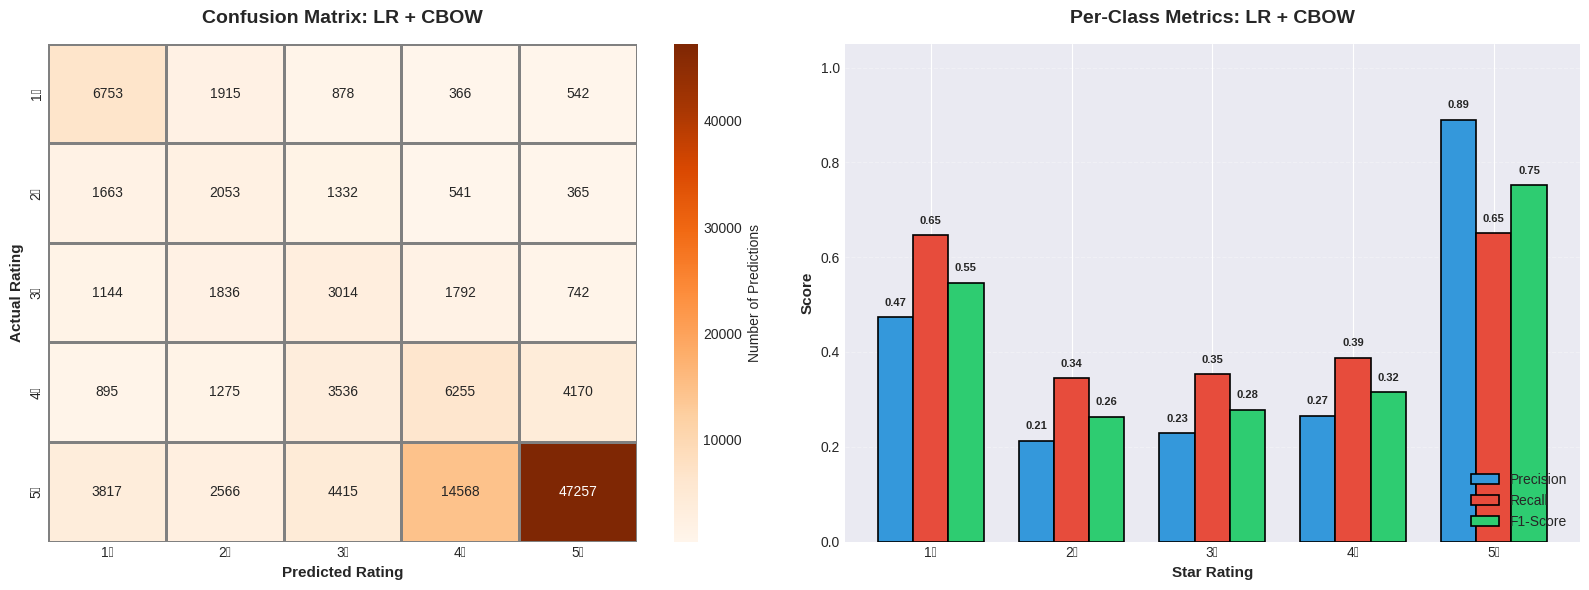

In [42]:
# EVALUATION - LOGISTIC REGRESSION + CBOW

print("MODEL EVALUATION: LOGISTIC REGRESSION + CBOW")

# Calculate metrics
accuracy_cbow = accuracy_score(y_test, y_pred_cbow)

precision_cbow, recall_cbow, f1_cbow, support_cbow = precision_recall_fscore_support(
    y_test, y_pred_cbow, average=None, zero_division=0
)

precision_macro_cbow, recall_macro_cbow, f1_macro_cbow, _ = precision_recall_fscore_support(
    y_test, y_pred_cbow, average='macro', zero_division=0
)

precision_weighted_cbow, recall_weighted_cbow, f1_weighted_cbow, _ = precision_recall_fscore_support(
    y_test, y_pred_cbow, average='weighted', zero_division=0
)

# Display results
print("OVERALL PERFORMANCE METRICS")

print(f"\nTest Set Performance:")
print(f"  Accuracy:                    {accuracy_cbow:.4f}")
print(f"\n  Macro-Averaged Metrics:")
print(f"    Precision:                 {precision_macro_cbow:.4f}")
print(f"    Recall:                    {recall_macro_cbow:.4f}")
print(f"    F1-Score:                  {f1_macro_cbow:.4f}")
print(f"\n  Weighted-Averaged Metrics:")
print(f"    Precision:                 {precision_weighted_cbow:.4f}")
print(f"    Recall:                    {recall_weighted_cbow:.4f}")
print(f"    F1-Score:                  {f1_weighted_cbow:.4f}")

# Per-class breakdown
print("PER-CLASS PERFORMANCE BREAKDOWN")

print(f"\n{'Rating':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
for i in range(5):
    print(f"{i+1}★ (Class {i})  {precision_cbow[i]:<12.4f} {recall_cbow[i]:<12.4f} "
          f"{f1_cbow[i]:<12.4f} {support_cbow[i]:<10,.0f}")
print("-" * 70)

# Confusion Matrix
cm_cbow = confusion_matrix(y_test, y_pred_cbow)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix
sns.heatmap(
    cm_cbow,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=['1★', '2★', '3★', '4★', '5★'],
    yticklabels=['1★', '2★', '3★', '4★', '5★'],
    cbar_kws={'label': 'Number of Predictions'},
    linewidths=1,
    linecolor='gray',
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix: LR + CBOW',
                 fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Predicted Rating', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Actual Rating', fontsize=11, fontweight='bold')

# Per-class metrics
x = np.arange(5)
width = 0.25

axes[1].bar(x - width, precision_cbow, width, label='Precision',
           color='#3498DB', edgecolor='black', linewidth=1.2)
axes[1].bar(x, recall_cbow, width, label='Recall',
           color='#E74C3C', edgecolor='black', linewidth=1.2)
axes[1].bar(x + width, f1_cbow, width, label='F1-Score',
           color='#2ECC71', edgecolor='black', linewidth=1.2)

axes[1].set_xlabel('Star Rating', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[1].set_title('Per-Class Metrics: LR + CBOW', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['1★', '2★', '3★', '4★', '5★'])
axes[1].legend(fontsize=10, loc='lower right')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim([0, 1.05])

# Add value labels
for i in range(5):
    if precision_cbow[i] > 0.05:
        axes[1].text(i - width, precision_cbow[i] + 0.02, f'{precision_cbow[i]:.2f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    if recall_cbow[i] > 0.05:
        axes[1].text(i, recall_cbow[i] + 0.02, f'{recall_cbow[i]:.2f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    if f1_cbow[i] > 0.05:
        axes[1].text(i + width, f1_cbow[i] + 0.02, f'{f1_cbow[i]:.2f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [43]:
# COMPARATIVE ANALYSIS

print("PHASE 3: COMPARATIVE ANALYSIS ACROSS EMBEDDINGS")

print("TABLE 1: OVERALL PERFORMANCE ACROSS ALL EMBEDDINGS")

comparison_data = {
    'Embedding': ['TF-IDF', 'Skip-gram', 'CBOW'],
    'Best C': [lr_tfidf_model.C, lr_skipgram_model.C, lr_cbow_model.C],
    'CV F1 (Mean)': [cv_f1_tfidf, cv_f1_skipgram, cv_f1_cbow],
    'CV F1 (Std)': [cv_std_tfidf, cv_std_skipgram, cv_std_cbow],
    'Test Accuracy': [accuracy_tfidf, accuracy_skipgram, accuracy_cbow],
    'Test Macro Precision': [precision_macro_tfidf, precision_macro_skipgram, precision_macro_cbow],
    'Test Macro Recall': [recall_macro_tfidf, recall_macro_skipgram, recall_macro_cbow],
    'Test Macro F1': [f1_macro_tfidf, f1_macro_skipgram, f1_macro_cbow],
    'Test Weighted F1': [f1_weighted_tfidf, f1_weighted_skipgram, f1_weighted_cbow]
}

comparison_df = pd.DataFrame(comparison_data)

# Format for better readability
for col in comparison_df.columns[1:]:
    comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:.4f}")

print("\n" + comparison_df.to_string(index=False))

# Identify best performer
best_idx = [f1_macro_tfidf, f1_macro_skipgram, f1_macro_cbow].index(
    max([f1_macro_tfidf, f1_macro_skipgram, f1_macro_cbow])
)
best_embedding = ['TF-IDF', 'Skip-gram', 'CBOW'][best_idx]
best_f1 = max([f1_macro_tfidf, f1_macro_skipgram, f1_macro_cbow])

print(f"\n BEST OVERALL PERFORMER: {best_embedding}")
print(f"   Test Macro F1-Score: {best_f1:.4f}")
print(f"   Cross-Validated F1: {[cv_f1_tfidf, cv_f1_skipgram, cv_f1_cbow][best_idx]:.4f}")

print("TABLE 2: PER-CLASS F1-SCORE COMPARISON")


perclass_data = {
    'Rating': ['1★ (Class 0)', '2★ (Class 1)', '3★ (Class 2)', '4★ (Class 3)', '5★ (Class 4)'],
    'TF-IDF F1': [f"{f:.4f}" for f in f1_tfidf],
    'Skip-gram F1': [f"{f:.4f}" for f in f1_skipgram],
    'CBOW F1': [f"{f:.4f}" for f in f1_cbow],
    'Support': [f"{int(s):,}" for s in support_tfidf]
}

perclass_df = pd.DataFrame(perclass_data)
print("\n" + perclass_df.to_string(index=False))
print("\n" + "=" * 100)

# Analyze per-class winners
print("\nBest Embedding Per Class:")
for i in range(5):
    f1_scores = [f1_tfidf[i], f1_skipgram[i], f1_cbow[i]]
    best_class_emb = ['TF-IDF', 'Skip-gram', 'CBOW'][f1_scores.index(max(f1_scores))]
    print(f"  {i+1}★: {best_class_emb} (F1 = {max(f1_scores):.4f})")


print("TABLE 3: EMBEDDING CHARACTERISTICS & COMPUTATIONAL EFFICIENCY")

characteristics_data = {
    'Embedding': ['TF-IDF', 'Skip-gram', 'CBOW'],
    'Feature Dimension': [X_train_tfidf.shape[1], X_train_skipgram.shape[1], X_train_cbow.shape[1]],
    'Representation Type': ['Sparse', 'Dense', 'Dense'],
    'Pre-training Required': ['No', 'Yes', 'Yes'],
    'Vocabulary Size': [len(tfidf_vectorizer.vocabulary_), len(skipgram_model.wv), len(cbow_model.wv)],
    'Memory Efficient': ['Yes (Sparse)', 'No (Dense)', 'No (Dense)'],
    'Best For': ['Linear Models', 'Rare Words', 'Frequent Words']
}

characteristics_df = pd.DataFrame(characteristics_data)
print("\n" + characteristics_df.to_string(index=False))
print("\n" + "=" * 100)

PHASE 3: COMPARATIVE ANALYSIS ACROSS EMBEDDINGS
TABLE 1: OVERALL PERFORMANCE ACROSS ALL EMBEDDINGS

Embedding Best C CV F1 (Mean) CV F1 (Std) Test Accuracy Test Macro Precision Test Macro Recall Test Macro F1 Test Weighted F1
   TF-IDF 1.0000       0.5110      0.0023        0.6461               0.4911            0.5668        0.5162           0.6726
Skip-gram 1.0000       0.4374      0.0009        0.5816               0.4211            0.4816        0.4378           0.6162
     CBOW 1.0000       0.4314      0.0010        0.5747               0.4142            0.4765        0.4309           0.6099

 BEST OVERALL PERFORMER: TF-IDF
   Test Macro F1-Score: 0.5162
   Cross-Validated F1: 0.5110
TABLE 2: PER-CLASS F1-SCORE COMPARISON

      Rating TF-IDF F1 Skip-gram F1 CBOW F1 Support
1★ (Class 0)    0.6246       0.5541  0.5462  10,454
2★ (Class 1)    0.3651       0.2703  0.2632   5,954
3★ (Class 2)    0.3864       0.2850  0.2777   8,528
4★ (Class 3)    0.4077       0.3218  0.3155  16,131
5★

COMPREHENSIVE COMPARATIVE VISUALIZATIONS


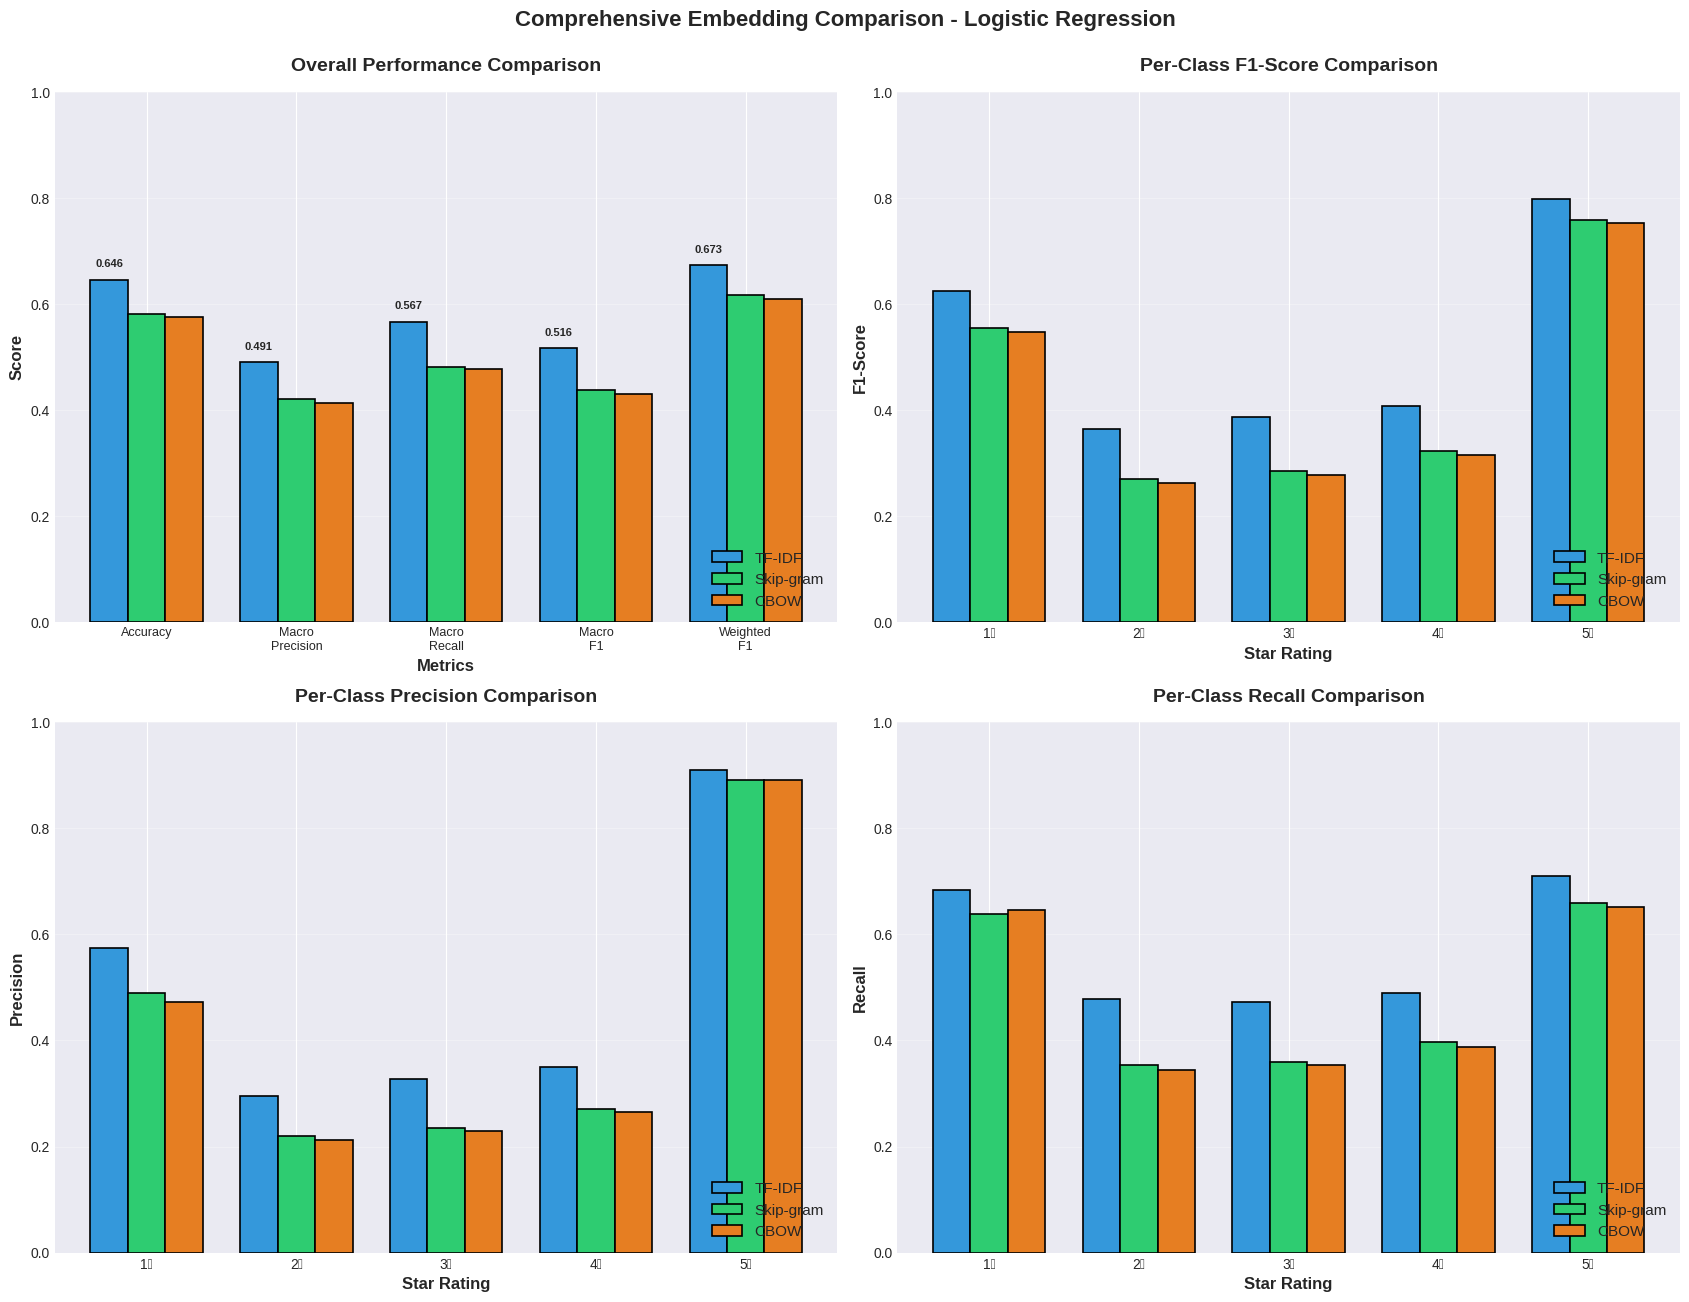

In [44]:
# COMPARATIVE VISUALIZATIONS

print("COMPREHENSIVE COMPARATIVE VISUALIZATIONS")

fig, axes = plt.subplots(2, 2, figsize=(17, 13))

# PLOT 1: Overall Metrics Comparison

metrics = ['Accuracy', 'Macro\nPrecision', 'Macro\nRecall', 'Macro\nF1', 'Weighted\nF1']
tfidf_scores = [accuracy_tfidf, precision_macro_tfidf, recall_macro_tfidf,
                f1_macro_tfidf, f1_weighted_tfidf]
skipgram_scores = [accuracy_skipgram, precision_macro_skipgram, recall_macro_skipgram,
                   f1_macro_skipgram, f1_weighted_skipgram]
cbow_scores = [accuracy_cbow, precision_macro_cbow, recall_macro_cbow,
               f1_macro_cbow, f1_weighted_cbow]

x = np.arange(len(metrics))
width = 0.25

axes[0, 0].bar(x - width, tfidf_scores, width, label='TF-IDF',
              color='#3498DB', edgecolor='black', linewidth=1.2)
axes[0, 0].bar(x, skipgram_scores, width, label='Skip-gram',
              color='#2ECC71', edgecolor='black', linewidth=1.2)
axes[0, 0].bar(x + width, cbow_scores, width, label='CBOW',
              color='#E67E22', edgecolor='black', linewidth=1.2)

axes[0, 0].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Overall Performance Comparison', fontsize=14, fontweight='bold', pad=15)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics, fontsize=9)
axes[0, 0].legend(fontsize=11, loc='lower right')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, 1.0])

# Add value labels for best metric
for i in range(len(metrics)):
    max_score = max(tfidf_scores[i], skipgram_scores[i], cbow_scores[i])
    if tfidf_scores[i] == max_score:
        axes[0, 0].text(i - width, tfidf_scores[i] + 0.02, f'{tfidf_scores[i]:.3f}',
                       ha='center', va='bottom', fontsize=8, fontweight='bold')
    if skipgram_scores[i] == max_score:
        axes[0, 0].text(i, skipgram_scores[i] + 0.02, f'{skipgram_scores[i]:.3f}',
                       ha='center', va='bottom', fontsize=8, fontweight='bold')
    if cbow_scores[i] == max_score:
        axes[0, 0].text(i + width, cbow_scores[i] + 0.02, f'{cbow_scores[i]:.3f}',
                       ha='center', va='bottom', fontsize=8, fontweight='bold')

# PLOT 2: Per-Class F1-Score Comparison


x_class = np.arange(5)
axes[0, 1].bar(x_class - width, f1_tfidf, width, label='TF-IDF',
              color='#3498DB', edgecolor='black', linewidth=1.2)
axes[0, 1].bar(x_class, f1_skipgram, width, label='Skip-gram',
              color='#2ECC71', edgecolor='black', linewidth=1.2)
axes[0, 1].bar(x_class + width, f1_cbow, width, label='CBOW',
              color='#E67E22', edgecolor='black', linewidth=1.2)

axes[0, 1].set_xlabel('Star Rating', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold', pad=15)
axes[0, 1].set_xticks(x_class)
axes[0, 1].set_xticklabels(['1★', '2★', '3★', '4★', '5★'])
axes[0, 1].legend(fontsize=11, loc='lower right')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].set_ylim([0, 1.0])

# PLOT 3: Precision Comparison


axes[1, 0].bar(x_class - width, precision_tfidf, width, label='TF-IDF',
              color='#3498DB', edgecolor='black', linewidth=1.2)
axes[1, 0].bar(x_class, precision_skipgram, width, label='Skip-gram',
              color='#2ECC71', edgecolor='black', linewidth=1.2)
axes[1, 0].bar(x_class + width, precision_cbow, width, label='CBOW',
              color='#E67E22', edgecolor='black', linewidth=1.2)

axes[1, 0].set_xlabel('Star Rating', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Per-Class Precision Comparison', fontsize=14, fontweight='bold', pad=15)
axes[1, 0].set_xticks(x_class)
axes[1, 0].set_xticklabels(['1★', '2★', '3★', '4★', '5★'])
axes[1, 0].legend(fontsize=11, loc='lower right')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim([0, 1.0])

# Recall Comparison


axes[1, 1].bar(x_class - width, recall_tfidf, width, label='TF-IDF',
              color='#3498DB', edgecolor='black', linewidth=1.2)
axes[1, 1].bar(x_class, recall_skipgram, width, label='Skip-gram',
              color='#2ECC71', edgecolor='black', linewidth=1.2)
axes[1, 1].bar(x_class + width, recall_cbow, width, label='CBOW',
              color='#E67E22', edgecolor='black', linewidth=1.2)

axes[1, 1].set_xlabel('Star Rating', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Per-Class Recall Comparison', fontsize=14, fontweight='bold', pad=15)
axes[1, 1].set_xticks(x_class)
axes[1, 1].set_xticklabels(['1★', '2★', '3★', '4★', '5★'])
axes[1, 1].legend(fontsize=11, loc='lower right')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim([0, 1.0])

plt.suptitle('Comprehensive Embedding Comparison - Logistic Regression',
            fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

In [45]:
# STATISTICAL SIGNIFICANCE TESTING


from scipy.stats import chi2

print("STATISTICAL SIGNIFICANCE TESTING")

def mcnemar_test(y_true, y_pred1, y_pred2):

    # Contingency table
    both_correct = np.sum((y_pred1 == y_true) & (y_pred2 == y_true))
    both_wrong = np.sum((y_pred1 != y_true) & (y_pred2 != y_true))
    model1_correct = np.sum((y_pred1 == y_true) & (y_pred2 != y_true))
    model2_correct = np.sum((y_pred1 != y_true) & (y_pred2 == y_true))

    # McNemar statistic with continuity correction
    statistic = (abs(model1_correct - model2_correct) - 1)**2 / (model1_correct + model2_correct + 1e-10)
    p_value = 1 - chi2.cdf(statistic, df=1)

    return statistic, p_value, model1_correct, model2_correct

print("PAIRWISE SIGNIFICANCE TESTS")

# Test 1: TF-IDF vs Skip-gram
stat1, p1, tfidf_only, sg_only = mcnemar_test(y_test, y_pred_tfidf, y_pred_skipgram)

print("\n1. TF-IDF vs Skip-gram:")
print(f"  Cases where only TF-IDF correct:     {tfidf_only:,}")
print(f"  Cases where only Skip-gram correct:  {sg_only:,}")
print(f"  McNemar χ² statistic:                {stat1:.4f}")
print(f"  p-value:                             {p1:.4f}")
print(f"  Significant at α=0.05:               {'Yes ✓' if p1 < 0.05 else 'No ✗'}")

if p1 < 0.05:
    winner = "TF-IDF" if tfidf_only > sg_only else "Skip-gram"
    print(f"  Conclusion: {winner} significantly outperforms the other")
else:
    print(f"  Conclusion: No significant difference in performance")

# Test 2: TF-IDF vs CBOW
stat2, p2, tfidf_only2, cbow_only = mcnemar_test(y_test, y_pred_tfidf, y_pred_cbow)

print("\n2. TF-IDF vs CBOW:")
print(f"  Cases where only TF-IDF correct:     {tfidf_only2:,}")
print(f"  Cases where only CBOW correct:       {cbow_only:,}")
print(f"  McNemar χ² statistic:                {stat2:.4f}")
print(f"  p-value:                             {p2:.4f}")
print(f"  Significant at α=0.05:               {'Yes ✓' if p2 < 0.05 else 'No ✗'}")

if p2 < 0.05:
    winner = "TF-IDF" if tfidf_only2 > cbow_only else "CBOW"
    print(f"  Conclusion: {winner} significantly outperforms the other")
else:
    print(f"  Conclusion: No significant difference in performance")

# Test 3: Skip-gram vs CBOW
stat3, p3, sg_only2, cbow_only2 = mcnemar_test(y_test, y_pred_skipgram, y_pred_cbow)

print("\n3. Skip-gram vs CBOW:")
print(f"  Cases where only Skip-gram correct:  {sg_only2:,}")
print(f"  Cases where only CBOW correct:       {cbow_only2:,}")
print(f"  McNemar χ² statistic:                {stat3:.4f}")
print(f"  p-value:                             {p3:.4f}")
print(f"  Significant at α=0.05:               {'Yes ✓' if p3 < 0.05 else 'No ✗'}")

if p3 < 0.05:
    winner = "Skip-gram" if sg_only2 > cbow_only2 else "CBOW"
    print(f"  Conclusion: {winner} significantly outperforms the other")
else:
    print(f"  Conclusion: No significant difference in performance")

# Summary
print("STATISTICAL TESTING SUMMARY")

results = [
    ("TF-IDF vs Skip-gram", p1),
    ("TF-IDF vs CBOW", p2),
    ("Skip-gram vs CBOW", p3)
]

print(f"\n{'Comparison':<25} {'p-value':<12} {'Significant?'}")
print("-" * 50)
for comparison, p_val in results:
    sig = "Yes ✓" if p_val < 0.05 else "No ✗"
    print(f"{comparison:<25} {p_val:<12.4f} {sig}")


STATISTICAL SIGNIFICANCE TESTING
PAIRWISE SIGNIFICANCE TESTS

1. TF-IDF vs Skip-gram:
  Cases where only TF-IDF correct:     16,928
  Cases where only Skip-gram correct:  9,602
  McNemar χ² statistic:                2022.4510
  p-value:                             0.0000
  Significant at α=0.05:               Yes ✓
  Conclusion: TF-IDF significantly outperforms the other

2. TF-IDF vs CBOW:
  Cases where only TF-IDF correct:     17,137
  Cases where only CBOW correct:       9,017
  McNemar χ² statistic:                2520.3854
  p-value:                             0.0000
  Significant at α=0.05:               Yes ✓
  Conclusion: TF-IDF significantly outperforms the other

3. Skip-gram vs CBOW:
  Cases where only Skip-gram correct:  6,502
  Cases where only CBOW correct:       5,708
  McNemar χ² statistic:                51.5028
  p-value:                             0.0000
  Significant at α=0.05:               Yes ✓
  Conclusion: Skip-gram significantly outperforms the other
STATIST

In [46]:
import pickle

print("MODEL PERSISTENCE")

print("\nSaving all trained models and vectorizers...")

models_to_save = {
    'lr_tfidf_model.pkl': lr_tfidf_model,
    'lr_skipgram_model.pkl': lr_skipgram_model,
    'lr_cbow_model.pkl': lr_cbow_model,
    'tfidf_vectorizer.pkl': tfidf_vectorizer,
    'skipgram_word2vec.pkl': skipgram_model,
    'cbow_word2vec.pkl': cbow_model
}

try:
    #  save to Google Drive
    save_path = '/content/drive/MyDrive/Grp 15 ML techniques/'

    for filename, model in models_to_save.items():
        with open(save_path + filename, 'wb') as f:
            pickle.dump(model, f)

    print(f"\n All models successfully saved to Google Drive:")
    print(f"  Location: {save_path}")
    print("\n  Files saved:")
    for filename in models_to_save.keys():
        print(f"    • {filename}")

except Exception as e:
    # Fallback to Colab runtime
    print(f"\n Could not save to Google Drive: {str(e)}")
    print("  Saving to Colab runtime instead...")

    for filename, model in models_to_save.items():
        with open(filename, 'wb') as f:
            pickle.dump(model, f)

    print(f"\n✓ Models saved to Colab runtime:")
    for filename in models_to_save.keys():
        print(f"    • {filename}")
    print("\n   Note: These files will be lost when the session ends.")
    print("     Download them manually or reconnect Google Drive.")



MODEL PERSISTENCE

Saving all trained models and vectorizers...

 All models successfully saved to Google Drive:
  Location: /content/drive/MyDrive/Grp 15 ML techniques/

  Files saved:
    • lr_tfidf_model.pkl
    • lr_skipgram_model.pkl
    • lr_cbow_model.pkl
    • tfidf_vectorizer.pkl
    • skipgram_word2vec.pkl
    • cbow_word2vec.pkl
